**NOTE: in order to use this notebook below, please choose whether you want to code in Python or R.**

You can choose the runtime environment using Edit -> Notebook Settings

In [ ]:
# Feel free to import anything you might want to use, beyond the below.
# We've included some helpful defaults for Python or R that you may want to use as a starting point.

##############################
# Python
##############################
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm



##############################
# R
##############################
# require(data.table)

# 1. Paper Replication
Below, we download three dataframes with tickers + reference data, daily returns, and features.

Dates:
* The ticker and feature dataframes are dated with the "data date". This is the date corresponding to when the observation happened (_t - 1_). We recieve the data the next morning (_t_) and can enter trades during market hours.
* The return dataframe gives _close-to-close_ forward residual returns. So, the return on date _t_ is the return from the close on _t_ to the close on _t + 1_. Residual returns are the component of returns unexplained by common risk factors like beta, size, etc.

Here are the columns and types for each dataframe. All rows are guaranteed to have a valid and unique pair of date / tickerid.

* Tickers

| Columns | Data Type | Description |
| --- | --- | --- |
| date | DATE | Observation reflects data as of market close on this day. |
| ticker | INTEGER | Company identifier |
| gic2 | INTEGER | Industry classification corresponding to the GIC industry system |
| marketcap | REAL | Market cap in millions of USD. |
| averagedailytradingvolume | REAL | Average daily trading volume in millions of USD. |
| earnings_to_price_ratio | REAL | Earnings to Price ratio |
| free_cash_flow_to_enterprise_value | REAL | LTM Free Cash Flow to Enterprise Value ratio |
| ebit_to_sales | REAL | LTM EBIT / Sales |
| ebitda_to_assets | REAL | LTM EBITDA / Total Assets |

* Returns

The return dataframe gives close-to-close forward residual arithmetic returns. So, the return on date t is the return from the close on t to the close on t + 1. Residual returns are the component of returns unexplained by common risk factors like beta, size, etc. Arithmetic returns are defined as (_(Price(t + k) / Price(t)) - 1_) - these are not logarithmic returns.

| Columns | Data Type | Description |
| --- | --- | --- |
| date | DATE | Observation reflects data as of market close on this day. |
| ticker | INTEGER | Company identifier |
| d1 | REAL | 1-day forward close-to-close residual arithmetic return|


* Features

| Columns | Data Type | Description |
| --- | --- | --- |
| date | DATE | Observation reflects data as of market close on this day. |
| ticker | INTEGER | Company identifier |
| gamma_sentiment | REAL | Sum of message-level sentiment from all relevant messages over the past 24-hours. |
| gamma_volume | REAL | Total number of relevant messages over the past 24-hours. |
| gamma_writers | REAL | Unique users who wrote relevant messages over the past 24-hours. |
| theta_sentiment | REAL | The same values, but from the "theta" social network. |
| theta_volume | REAL | The same values, but from the "theta" social network. |
| theta_writers | REAL | The same values, but from the "theta" social network. |

Please use the "gamma" dataset until asked to do so.

# 1. Paper Replication

## 1.1
First, create a single dataframe correctly combining all three dataframes above.

Hints:
* A good choice of organization here will pay dividends across this test.
* Be careful how you align dates here between returns and features. Perhaps read the date definitions above again if you need a refresher. Think about how a misalignment here may affect your results downstream as a sanity check. As a hint, simply joining the three dataframes on “date” as-is is wrong.
* We expect you to follow idiomatic coding patterns for the libraries you choose to use.

In [ ]:
# I believe missing data will be quite common here. To solve that, we first take steps to be more aware in regard to potential missing data.

#Make a master calendar of existing trading days, as we will use this again in the future to detect missing data:
trading_days = pd.concat([
    tickers['date'],
    features['date'],
    returns['date']
]).drop_duplicates().sort_values()

#Since this only works under the assumption that data errors are random and independent across tickers, so even for some missing rows for one particular ticker, we will have data from that trading day from another ticker.
#To detect systemic data errors, such as vendor issues, we do a coverage check,

daily_counts = (
    features.groupby('date')['tickerid'].count() /
    features['tickerid'].nunique()
)

threshold = 0.1  # if <10% coverage, treat as systematic issue
suspect_days = daily_counts[daily_counts < threshold].index
suspect_days

Index(['2015-01-22', '2015-01-29', '2015-03-05', '2015-03-19', '2015-04-01',
       '2015-06-11', '2015-07-01', '2015-07-09', '2018-06-28', '2018-10-10',
       '2018-11-09', '2018-11-15', '2018-11-20', '2018-12-13', '2018-12-20',
       '2018-12-21', '2018-12-26', '2018-12-27', '2018-12-28', '2019-03-21',
       '2019-08-01', '2019-08-08', '2019-08-22', '2019-08-29', '2019-08-30',
       '2019-09-11'],
      dtype='object', name='date')

In [ ]:
# Make working copies so we can transform safely without altering the original dataframes
features_clean = features.copy()
tickers_clean = tickers.copy()
returns_clean = returns.copy()

In [ ]:
# We can see that the suspect dates are likely not holidays, as they don't repeat year over year + there are no missing days in 2017. Thus, they are likely vendor issues.
#We wish to drop them across all datasets at once so every join is consistent.
# Drop bad dates from tickers
tickers_clean = tickers_clean[~tickers_clean['date'].isin(suspect_days)]

# Drop bad dates from features
features_clean = features_clean[~features_clean['date'].isin(suspect_days)]

# Drop bad dates from returns
returns_clean = returns_clean[~returns_clean['date'].isin(suspect_days)]

# Drop bad dates from trading days
trading_days = trading_days[~trading_days.isin(suspect_days)]

In [ ]:
# Normalize types so merges, sorting, joins, etc work reliably later
tickers_clean["date"] = pd.to_datetime(tickers_clean["date"])
returns_clean["date"] = pd.to_datetime(returns_clean["date"])
features_clean["date"] = pd.to_datetime(features_clean["date"])

tickers_clean["tickerid"] = tickers_clean["tickerid"].astype(int)
returns_clean["tickerid"] = returns_clean["tickerid"].astype(int)
features_clean["tickerid"] = features_clean["tickerid"].astype(int)

In [ ]:
#As requested, keep only gamma features for now
gamma_cols = [c for c in features_clean.columns if c.startswith("gamma_")]
features_clean = features_clean[["tickerid", "date"] + gamma_cols]

#since we will only use averagedailytradingvolume from tickers for now, just keep that:
tickers_clean=tickers_clean[["date","tickerid", "averagedailytradingvolume"]]

In [ ]:
# For features/tickers dfs, date represents the info as of market close on t-1. However, for returns, date represents the forward return from close(t) to close(t+1).
# Even though the features are dated t-1, we only observe them on the morning of t, so they should be paired with returns from t to t+1, as that is what we are trying to predict. Thus, we need to shifting the features one day down for alignment.

# As we saw above, we have missing data for valid trading days.
#As such, in order to accurately shift up, we shift up the dates by next available trading day instead of the returns for more stability. This handles missing dates because only exact overlaps with features survive the merge.
# We cannot use any form of interpolation/ffill, since the only features we care about (avg daily trading volume, gamma_sentiment, d1, etc) are too fast moving


def relabel_df_to_next_day(df, trading_days):
  aligned = []
  for tid, g in df.groupby("tickerid"):
    # reindex this ticker to full trading calendar
    g = g.set_index("date").reindex(trading_days).sort_index()
    g["tickerid"] = tid

    # relabel: each feature row becomes valid for the NEXT trading day
    g["date"] = g.index.to_series().shift(-1)
    aligned.append(g.reset_index(drop=True))
  f_aligned = pd.concat(aligned, ignore_index=True)
  f_aligned["date"] = pd.to_datetime(f_aligned["date"])
  return f_aligned.dropna(how="any")



features_shifted = relabel_df_to_next_day(features_clean,trading_days)
tickers_shifted = relabel_df_to_next_day(tickers_clean,trading_days)

In [ ]:
#merging everything together

#Master calendar of market info
master = returns_clean[["date", "tickerid", "d1"]].merge(tickers_shifted, on=["tickerid","date"], how="inner").sort_values(["tickerid","date"]).reset_index(drop=True)


merged_df = master.merge(features_shifted, on=["tickerid","date"], how="left")

merged_df = merged_df.sort_values(["tickerid","date"]).reset_index(drop=True)

merged_df.head()

,date,tickerid,d1,averagedailytradingvolume,gamma_sentiment,gamma_volume,gamma_writers
0,2015-01-05,1,-0.006974,26.997211,NaN,NaN,NaN
1,2015-01-06,1,0.001613,27.653274,NaN,NaN,NaN
2,2015-01-07,1,0.001941,27.643406,NaN,NaN,NaN
3,2015-01-08,1,-0.001417,28.459042,NaN,NaN,NaN
4,2015-01-09,1,0.005557,28.161071,NaN,NaN,NaN


## 1.2
Now, re-create the X (right-hand side) and y (left-hand side) variables from the paper. Be sure to perform exploratory analysis and clean-up data issues. As a hint, there are data issues and some values are just plain wrong.

EDA and data cleaning:

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# I want to check the correlation between each feature and d1 score
from scipy.stats import spearmanr, pearsonr

def compute_daily_ic(df, feature):
    ics = []
    for date, grp in df.groupby("date"):
        # z-score cross-sectionally
        x = (grp[feature] - grp[feature].mean()) / grp[feature].std(ddof=0)
        y = grp["d1"]

        if x.notna().sum() > 5:
            pear = pearsonr(x, y)[0]
            spear = spearmanr(x, y)[0]
            ics.append({"date": date, "pearson": pear, "spearman": spear})
    return pd.DataFrame(ics)


ic_sent = compute_daily_ic(merged_df.dropna(), "gamma_sentiment")
ic_vol  = compute_daily_ic(merged_df.dropna(), "gamma_volume")
ic_wr   = compute_daily_ic(merged_df.dropna(), "gamma_writers")

for ic, name in [(ic_sent, "sentiment"), (ic_vol, "volume"), (ic_wr, "writers")]:
    mean_ic = ic['pearson'].mean()
    tstat = mean_ic / (ic['pearson'].std(ddof=1)/len(ic)**0.5)
    print(f"{name}: mean_IC={mean_ic:.4f}, t={tstat:.2f}")

  # We see the sentiment's T-score being 2.45 indicates statistically significant, suggesting positive sentiment today is weakly predictive of higher residual returns tomorrow.
  # other two are basically noise and uncorrelated.

sentiment: mean_IC=0.0044, t=2.45
volume: mean_IC=0.0006, t=0.36
writers: mean_IC=0.0011, t=0.65


In [ ]:
# Monotonic sorting to see how reliable the signal is
def quantile_portfolio(df, feature, q=5):
    results = []
    for date, grp in df.groupby("date"):
        grp = grp.copy()
        grp["bin"] = pd.qcut(grp[feature].rank(method="first"), q, labels=False)

        # mean forward return per bin
        bin_rets = grp.groupby("bin")["d1"].mean()
        results.append(bin_rets)

    return pd.DataFrame(results)

quint_sent = quantile_portfolio(merged_df, "gamma_sentiment", q=5)
long_short = (quint_sent[4] - quint_sent[0]).mean()
tstat = (quint_sent[4] - quint_sent[0]).mean() / (
    (quint_sent[4] - quint_sent[0]).std(ddof=1)/len(quint_sent)**0.5
)
print(f"mean={long_short:.4f}, t={tstat:.2f}")

# We find that our t stat indicates it is not statistically significant.

mean=0.0174, t=0.39


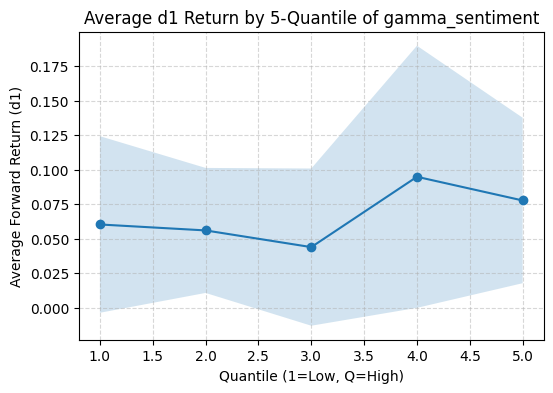

In [ ]:
#Plotting the quantiles to investigate behavior:
avg_curve = quint_sent.mean()
se_curve  = quint_sent.std(ddof=1) / np.sqrt(len(quint_sent))

xs = np.arange(1, 6)
plt.figure(figsize=(6,4))
plt.plot(xs, avg_curve.values, marker="o")
plt.fill_between(xs, (avg_curve - 1.96*se_curve).values,
                      (avg_curve + 1.96*se_curve).values,
                      alpha=0.2)
plt.title(f"Average d1 Return by {5}-Quantile of gamma_sentiment")
plt.xlabel("Quantile (1=Low, Q=High)")
plt.ylabel("Average Forward Return (d1)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#We notice Q4 and Q5 average returns are consistently positive and higher than the lower buckets.
#This suggests the signal is concentrated in the right tail. This makes sense, as extreme sentiment is informative while most chatter is noise

Gamma vol max: 834.0
Gamma vol min: 0.0
Gamma vol mean: 5.911662251122054
Gamma vol median: 3.0


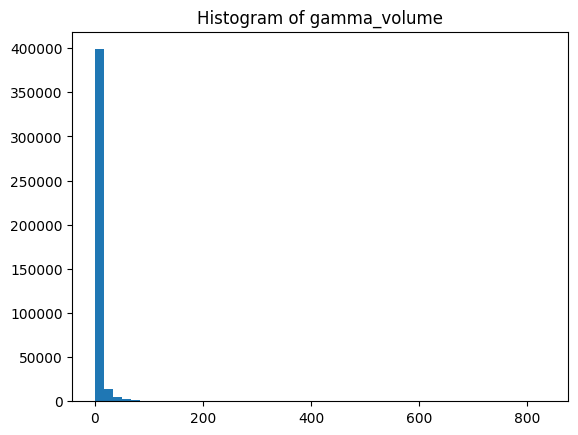

In [ ]:
# Histogram of gamma_volume, should expect the histogram to look like a right-skewed distribution

print(f"Gamma vol max: {merged_df['gamma_volume'].max()}")
print(f"Gamma vol min: {merged_df['gamma_volume'].min()}")
print(f"Gamma vol mean: {merged_df['gamma_volume'].mean()}")
print(f"Gamma vol median: {merged_df['gamma_volume'].median()}")

plt.hist(merged_df["gamma_volume"].dropna(), bins=50)
plt.title("Histogram of gamma_volume")
plt.show()

Gamma Sent max: 41.691
Gamma Sent min: 0.001
Gamma Sent mean: 0.27171054801727035
Gamma Sent median: 0.122


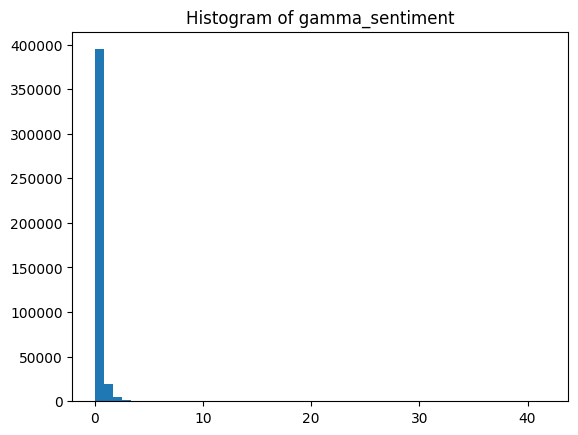

In [ ]:
# Histogram of gamma_sentiments, should expect the histogram to look like a right-skewed distribution

print(f"Gamma Sent max: {merged_df['gamma_sentiment'].max()}")
print(f"Gamma Sent min: {merged_df['gamma_sentiment'].min()}")
print(f"Gamma Sent mean: {merged_df['gamma_sentiment'].mean()}")
print(f"Gamma Sent median: {merged_df['gamma_sentiment'].median()}")

plt.hist(merged_df["gamma_sentiment"].dropna(), bins=50)
plt.title("Histogram of gamma_sentiment")
plt.show()

Gamma Sent max: 3.042
Gamma Sent min: 0.002
Gamma Sent mean: 0.26002606198192385
Gamma Sent median: 0.122


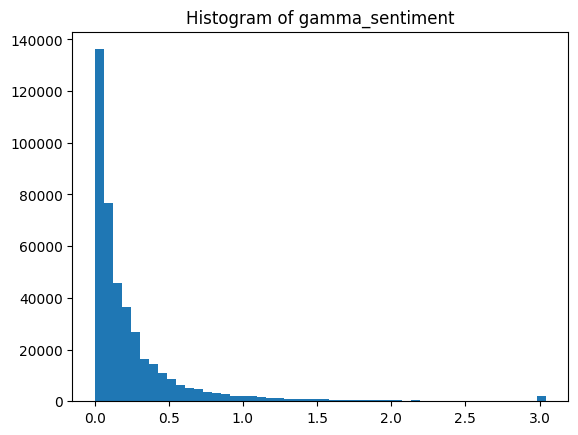

Gamma Volume max: 77.0
Gamma Volume min: 0.0
Gamma Volume mean: 5.69621605994398
Gamma Volume median: 3.0


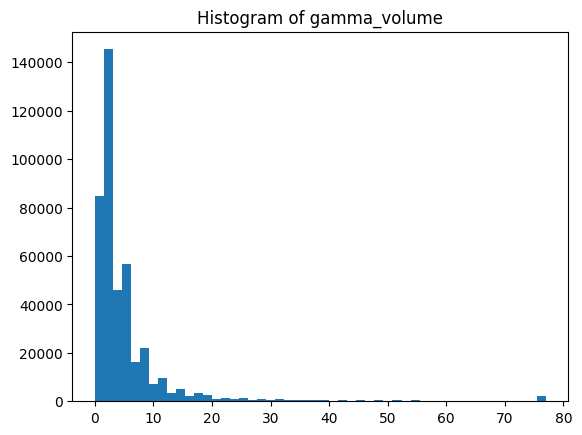

In [ ]:
#In this case, I think it is best to clip outliers.
#Even if that point is real, it can hurt generalization, as the model learns to over-weight rare spikes. Clipping prevents this and hopefully gives us a better model.

#However, I still find the sentiment score puzzling. In my experience sentiment was scored from -1 to 1, with -1 indicating negative and 1 indicating positive.
# Suppose sentiment score here is the absolute value, since it is strictly positive?

merged_df_cleaned = merged_df.copy()


#clipping gamma_sentiment
q_lo = merged_df_cleaned["gamma_sentiment"].quantile(0.005)   # 0.5th percentile
q_hi = merged_df_cleaned["gamma_sentiment"].quantile(0.995)   # 99.5th percentile
merged_df_cleaned["gamma_sentiment"] = merged_df_cleaned["gamma_sentiment"].clip(lower = q_lo, upper=q_hi)


print(f"Gamma Sent max: {merged_df_cleaned['gamma_sentiment'].max()}")
print(f"Gamma Sent min: {merged_df_cleaned['gamma_sentiment'].min()}")
print(f"Gamma Sent mean: {merged_df_cleaned['gamma_sentiment'].mean()}")
print(f"Gamma Sent median: {merged_df_cleaned['gamma_sentiment'].median()}")


plt.hist(merged_df_cleaned["gamma_sentiment"].dropna(), bins=50)
plt.title("Histogram of gamma_sentiment")
plt.show()


#clipping gamma_volume
q_lo = merged_df_cleaned["gamma_volume"].quantile(0.005)   # 0.5th percentile
q_hi = merged_df_cleaned["gamma_volume"].quantile(0.995)   # 99.5th percentile
merged_df_cleaned["gamma_volume"] = merged_df_cleaned["gamma_volume"].clip(lower = q_lo, upper=q_hi)


print(f"Gamma Volume max: {merged_df_cleaned['gamma_volume'].max()}")
print(f"Gamma Volume min: {merged_df_cleaned['gamma_volume'].min()}")
print(f"Gamma Volume mean: {merged_df_cleaned['gamma_volume'].mean()}")
print(f"Gamma Volume median: {merged_df_cleaned['gamma_volume'].median()}")

plt.hist(merged_df_cleaned["gamma_volume"].dropna(), bins=50)
plt.title("Histogram of gamma_volume")
plt.show()

d1 max: 2657.40182238672
d1 min: -1593.95234941238
d1 mean: 0.006318876877288871
d1 median: -3.5942988499999996e-05


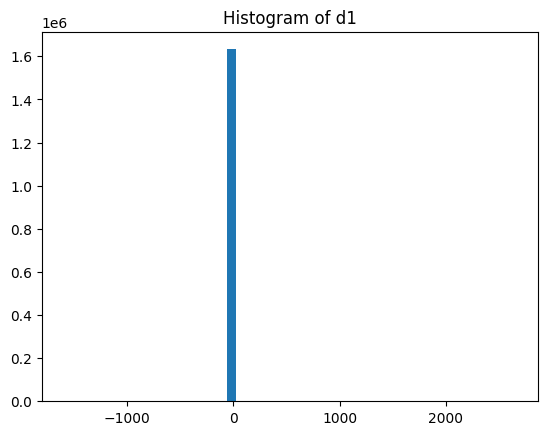

In [ ]:
#Histogram of daily returns

print(f"d1 max: {merged_df_cleaned['d1'].max()}")
print(f"d1 min: {merged_df_cleaned['d1'].min()}")
print(f"d1 mean: {merged_df_cleaned['d1'].mean()}")
print(f"d1 median: {merged_df_cleaned['d1'].median()}")

plt.hist(merged_df_cleaned["d1"].dropna(), bins=50)
plt.title("Histogram of d1")
plt.show()

#d1 returns of -1522.66914966671 is ridiculous. In fact, we can't have any d1 scores below -1.

d1 max: 0.05355873228999998
d1 min: -0.04593118867
d1 mean: 0.00020419697938111142
d1 median: -1.6045904e-06


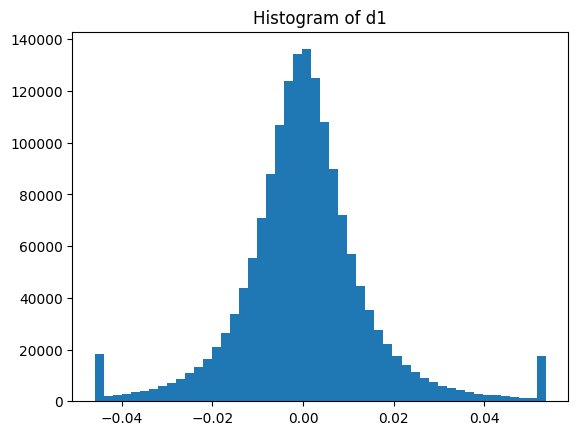

In [ ]:
# encounter wild outliers --> likely data errors, as a company stock cannot drop more than 100% and have its value go into the negatives.
# We will drop all negative values greater than 100, and clip all other extremes since it is very unlikely that a stock grew 26.5x overnight, so we shouldn't train to rely on it.

merged_df_cleaned = merged_df_cleaned[merged_df_cleaned["d1"] >= -1.0]
upper_cutoff = merged_df_cleaned["d1"].quantile(0.99)
lower_cutoff = merged_df_cleaned["d1"].quantile(0.01)
merged_df_cleaned["d1"] = merged_df_cleaned["d1"].clip(lower = lower_cutoff, upper=upper_cutoff)


print(f"d1 max: {merged_df_cleaned['d1'].max()}")
print(f"d1 min: {merged_df_cleaned['d1'].min()}")
print(f"d1 mean: {merged_df_cleaned['d1'].mean()}")
print(f"d1 median: {merged_df_cleaned['d1'].median()}")

plt.hist(merged_df_cleaned["d1"].dropna(), bins=50)
plt.title("Histogram of d1")
plt.show()

Rebuilding the dataframe from the paper:

In [ ]:
#Building a 5 day look forward for y, using a Master calendar from returns for trading days. We employ a strict approach, where days where we don't have data for exactly 5 days forward are dropped
#This avoids apples-to-oranges comparisons (e.g., “five-day” signals based on three observed days plus fillers) while Y compounds over exactly five days.
# We do not impute or interpolate because daily returns and stock-level sentiment are intermittent and don't persist long. If, for missing days, skip the missing days and compound over available ones and then normalize, we would introduce noise and bias.

def build_y_forward(df, trading_days, window_size=5):
  r = df.copy()
  r = r.sort_values(["tickerid", "date"]).reset_index(drop=True)

  out_parts = []

  for tid, g in r.groupby("tickerid", group_keys=False):
    # Reindex this ticker to the master trading-day calendar
    gi = (g.set_index("date").reindex(trading_days).sort_index())
    gi["tickerid"] = tid

    # daily forward returns for this ticker on the master calendar
    s = gi["d1"]

    #Forward 5-day product: (1+d1_t) * (1+d_{t+1}) * ... * (1+d_{t+4}) - 1
    prod = (1 + s)

    for k in range(1,window_size+1):
      prod = prod * (1 + s.shift(-k))
      gi["y"] = prod - 1.

    #prune rows were y is null (to make sure we had all 5 forward trading days) or the original ticker had a record on that 'date'
    keep = gi["y"].notna() & s.notna()
    kept = gi.loc[keep].copy()
    kept = kept.reset_index().rename(columns={"index": "date"})
    out_parts.append(kept)


  y_df = pd.concat(out_parts, ignore_index=True)
  return y_df

In [ ]:
#Building a 5 day look backwards for 5 day rolling sentiment (rs5), using a Master calendar from returns for trading days.
#This time, we use a lenient approach. My thoughts for this choice is because unlike stock day-to-day changes, sentiment persists. If theres hype on twitter on day one its unlikely to have completely died by day 2.
#Thus, for windows where we are missing data, we normalize the data we do have and scale to 5-day horizon.
# We also implement time weighted the inputs, as described in the paper.

def build_r5_backwards(df,trading_days, window_size=5):
  r = df.copy().dropna()
  r = r.sort_values(["tickerid", "date"]).reset_index(drop=True)

  #setup for time weighted
  base = np.array([max(0, -k + window_size) for k in range(1,window_size+1)], dtype=float)
  wts = pd.Series(base, index=range(window_size))


  out_parts = []
  for tid, g in r.groupby("tickerid", group_keys=False):
    # Reindex this ticker to the master trading-day calendar
    gi = (g.set_index("date").reindex(trading_days).sort_index())
    gi["tickerid"] = tid

    s = gi["gamma_sentiment"]

    #Backwards 5-day sentiment sum
    shifted = pd.concat([s.shift(k) for k in range(window_size)], axis=1)
    shifted.columns = range(window_size)

    # Numerator: weighted sum over available days (NaNs ignored)
    num = (shifted * wts).sum(axis=1, skipna=True)

    # Denominator: sum of weights for the *available* (non-NaN) entries only
    den = (shifted.notna() * wts).sum(axis=1)

    # Lenient weighted average, rescaled to 5 day window
    gi["rs5_gamma"] = num / den.replace({0.0: np.nan})

    kept = gi.loc[gi["rs5_gamma"].notna()].reset_index(names="date")
    kept["tickerid"] = tid
    out_parts.append(kept)

  rs5_df = pd.concat(out_parts, ignore_index=True)
  return rs5_df[["date", "tickerid", "rs5_gamma"]]

In [ ]:
model_df_y = build_y_forward(merged_df_cleaned, trading_days=trading_days)

model_df_r5=build_r5_backwards(merged_df_cleaned, trading_days=trading_days)

In [ ]:
#Building the 5 day normalized volume lookback window
def build_NV5_backwards(df,trading_days, window_size=5):
  r = df.copy()
  r = r.sort_values(["tickerid", "date"]).reset_index(drop=True)

  r["NormalizedVolume_gamma"]=r["gamma_volume"]/(np.log1p(r["averagedailytradingvolume"]).clip(lower=np.log1p(100.0)))

  #setup for time weighted
  base = np.array([max(0, -k + window_size) for k in range(1,window_size+1)], dtype=float)
  wts = pd.Series(base, index=range(window_size))


  out_parts = []
  for tid, g in r.groupby("tickerid", group_keys=False):
    # Reindex this ticker to the master trading-day calendar
    gi = (g.set_index("date").reindex(trading_days).sort_index())
    gi["tickerid"] = tid

    s = gi["NormalizedVolume_gamma"]

    #Backwards 5-day sentiment sum
    shifted = pd.concat([s.shift(k) for k in range(1,window_size+1)], axis=1)
    shifted.columns = range(window_size)

    # Numerator: weighted sum over available days (NaNs ignored)
    num = (shifted * wts).sum(axis=1, skipna=True)
    gi["nv5_gamma"] = num


    kept = gi.loc[gi["nv5_gamma"].notna()].reset_index(names="date")
    kept["tickerid"] = tid
    out_parts.append(kept)

  rs5_df = pd.concat(out_parts, ignore_index=True)
  return rs5_df[["date", "tickerid", "nv5_gamma"]]

In [ ]:
#Building the 63 day normalized volume lookback window
def build_63NV_backwards_with_std(df, trading_days, window_size=63):
    r = df.sort_values(["tickerid", "date"]).reset_index(drop=True)

    trading_days = pd.Series(trading_days).drop_duplicates().sort_values()

    r["NormalizedVolume_gamma"]=r["gamma_volume"]/(np.log1p(r["averagedailytradingvolume"]).clip(lower=np.log1p(100.0)))

    # time decay weights
    base = np.array([max(0, -k + window_size) for k in range(1,window_size+1)], dtype=float)
    wts = pd.Series(base, index=range(window_size))

    out_parts = []
    for tid, g in r.groupby("tickerid", group_keys=False):
        gi = g.set_index("date").reindex(trading_days).sort_index()
        gi["tickerid"] = tid

        s = gi["NormalizedVolume_gamma"]

        shifted = pd.concat([s.shift(k) for k in range(1,window_size+1)], axis=1)
        shifted.columns = range(window_size)

        W = (shifted.notna() * wts).astype(float)
        sum_w = W.sum(axis=1)
        sum_w2 = (W**2).sum(axis=1)

        num = (shifted.fillna(0.0) * W).sum(axis=1)
        mu = num / (sum_w.replace(0.0, np.nan))

        # unbiased weighted sample variance (reliability weights)
        centered2 = (shifted.sub(mu, axis=0))**2
        num_var = (centered2 * W).sum(axis=1)
        denom_var = sum_w - (sum_w2 / sum_w.replace(0.0, np.nan))

        var = num_var / denom_var.replace(0.0, np.nan)
        std = np.sqrt(var)

        # effective sample size; require >= 2 for a valid std
        n_eff = (sum_w**2) / sum_w2.replace(0.0, np.nan)
        std[n_eff < 2] = np.nan  # not enough points to estimate std

        gi["NormalizedVolume_gamma_63_mean"] = mu
        gi["NormalizedVolume_gamma_63_std"] = std

        kept = gi.loc[gi["NormalizedVolume_gamma_63_mean"].notna()].reset_index(names="date")
        kept["tickerid"] = tid
        out_parts.append(kept)

    rs5_df = pd.concat(out_parts, ignore_index=True)
    return rs5_df[["date", "tickerid", "NormalizedVolume_gamma_63_mean", "NormalizedVolume_gamma_63_std"]]

In [ ]:
#Building 5 day and 63 day lookback windows, as specified in the paper
#Replace all the 0's with NaN, since the minimum gamma_sentiment is 0.002 > 0, so any row with 0 is just fully empty window and can be disregarded.
model_df_NV5=build_NV5_backwards(merged_df_cleaned, trading_days=trading_days).replace(0.0, np.nan)
model_df_63NV=build_63NV_backwards_with_std(merged_df_cleaned, trading_days=trading_days).replace(0.0, np.nan)

In [ ]:
#merging the df together into one paper_df, as described in the paper
paper_df = (model_df_y.merge(model_df_r5.dropna(), on=["tickerid", "date"], how="left").merge(model_df_NV5.dropna(), on=["tickerid", "date"], how="left").merge(model_df_63NV.dropna(), on=["tickerid", "date"], how="left"))

# #clip standard deviation so absvol doesn't blow up or disappear
upper_cutoff = paper_df["NormalizedVolume_gamma_63_std"].quantile(0.99)
lower_cutoff = paper_df["NormalizedVolume_gamma_63_std"].quantile(0.01)
paper_df["NormalizedVolume_gamma_63_std"] = paper_df["NormalizedVolume_gamma_63_std"].clip(lower = lower_cutoff, upper=upper_cutoff)

#Solve for abnormal volume and the second model's X variable as described in the paper
paper_df["abvol"] = (paper_df["nv5_gamma"]-paper_df["NormalizedVolume_gamma_63_mean"])/paper_df["NormalizedVolume_gamma_63_std"]


#Winsorize relevant variables, for better stability and avoid bias from outliers:
def cs_winsorize(g, cols, p=0.01):
    for c in cols:
        lo, hi = g[c].quantile(p), g[c].quantile(1-p)
        g[c] = g[c].clip(lo, hi)
    return g
paper_df = paper_df.groupby("date", group_keys=False).apply(cs_winsorize, ["y", "rs5_gamma", "abvol"], 0.01)
paper_df["X2"]= paper_df["rs5_gamma"]*paper_df["abvol"]

paper_df=paper_df.dropna()
paper_df.head()

/tmp/ipython-input-2099841639.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paper_df = paper_df.groupby("date", group_keys=False).apply(cs_winsorize, ["y", "rs5_gamma", "abvol"], 0.01)


,date,tickerid,d1,averagedailytradingvolume,gamma_sentiment,gamma_volume,gamma_writers,y,rs5_gamma,nv5_gamma,NormalizedVolume_gamma_63_mean,NormalizedVolume_gamma_63_std,abvol,X2
27,2015-02-17,1,-0.007549,47.794957,0.322,3.0,3.000,-0.037356,0.335000,3.683544,0.579015,0.145621,21.319295,7.141964
79,2015-05-06,1,-0.007082,25.451216,0.507,5.0,5.000,-0.013957,0.317571,0.866716,0.331037,0.172814,3.099736,0.984388
129,2015-07-22,1,0.008197,35.994718,1.821,8.0,6.000,-0.006069,1.316667,0.650037,1.137565,1.246395,-0.391150,-0.515015
137,2015-08-03,1,-0.041011,26.605402,0.132,2.0,2.000,-0.049855,0.142667,3.250186,1.275512,0.940742,2.099061,0.299466
138,2015-08-04,1,0.028907,28.655838,2.616,13.0,9.997,-0.011070,1.378000,3.900223,1.105637,0.905164,3.087382,4.254413


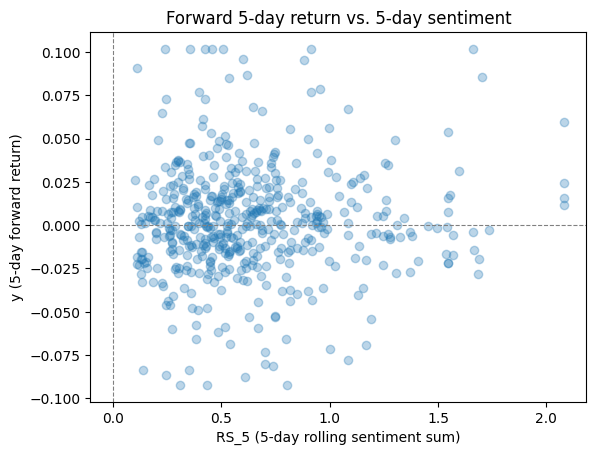

In [ ]:
#Observe the patterns between y and rs5, to sanity check results
counts = paper_df["date"].value_counts()
top_day  = counts.idxmax()

df_day = (
    paper_df.loc[paper_df["date"] == top_day, ["rs5_gamma", "y"]]
    .dropna()
)


plt.scatter(df_day["rs5_gamma"], df_day["y"], alpha=0.3)
plt.axhline(0, color="gray", linewidth=0.8, linestyle="--")
plt.axvline(0, color="gray", linewidth=0.8, linestyle="--")

plt.xlabel("RS_5 (5-day rolling sentiment sum)")
plt.ylabel("y (5-day forward return)")
plt.title("Forward 5-day return vs. 5-day sentiment")
plt.show()

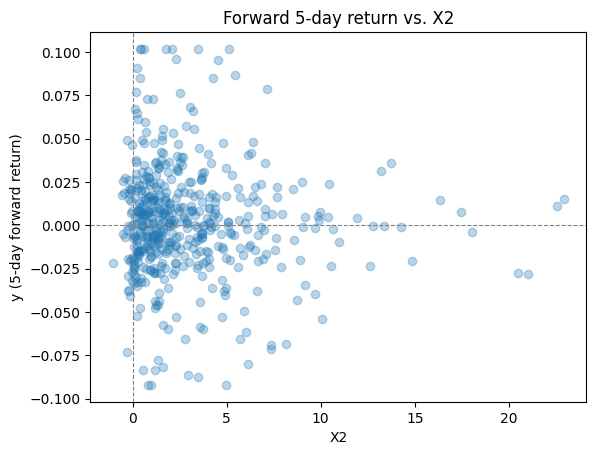

In [ ]:
#Observe the patterns between y and X2, to sanity check results
counts = paper_df["date"].value_counts()
top_day  = counts.idxmax()

df_day = (
    paper_df.loc[paper_df["date"] == top_day, ["X2", "y"]]
    .dropna()
)


plt.scatter(df_day["X2"], df_day["y"], alpha=0.3)
plt.axhline(0, color="gray", linewidth=0.8, linestyle="--")
plt.axvline(0, color="gray", linewidth=0.8, linestyle="--")

plt.xlabel("X2")
plt.ylabel("y (5-day forward return)")
plt.title("Forward 5-day return vs. X2")
plt.show()

These plots line up with the paper's results: it appears that most of the data points are clumped around (0,0) for both models, indicating that the paper's  near 0 slope and R^2 makes sense.

## 1.3
Recreate the models from the paper. If your results are substantially different from those in the paper, explain why.

In [ ]:
#Model 1:
# y ~ beta * rs5

# helper: Newey–West SE for the mean of a time series (lag L)
def nw_se_mean(x, maxlag=4):
    x = np.asarray(x, dtype=float)
    T = x.size
    x_c = x - x.mean()
    gamma0 = (x_c @ x_c) / T
    S = gamma0
    for L in range(1, maxlag + 1):
        gammaL = (x_c[L:] @ x_c[:-L]) / T
        w = 1.0 - L / (maxlag + 1.0)
        S += 2.0 * w * gammaL
    var_mean = S / T
    return np.sqrt(var_mean)

# FM regression: r_{i,t+1} ~ alpha_t + beta_t * rs5_{i,t}
#Done cross sectionally across dates, so we can test "Does the signal rank winners vs losers today?" This way it balances out for market/sector shocks which hit all stocks on a day.
#Cross-sectional fit focuses on relative differences.
tmp = paper_df[["date", "y", "rs5_gamma"]].dropna().copy()
tmp["date"] = pd.to_datetime(tmp["date"])

betas = []
r2s = []
ns  = []

MIN_N = 30  # require enough names in each cross-section
for dt, g in tmp.groupby("date"):
    if len(g) < MIN_N:
        continue
    X = sm.add_constant(g["rs5_gamma"])
    y = g["y"]
    res = sm.OLS(y, X).fit()
    betas.append(res.params["rs5_gamma"])
    r2s.append(res.rsquared)
    ns.append(len(g))

betas = np.asarray(betas, dtype=float)
T = len(betas)
if T == 0:
    raise RuntimeError("No cross-sections met the minimum N requirement.")

beta_hat = betas.mean()
se_hat   = nw_se_mean(betas, maxlag=4)  # HAC on daily betas (lag≈4 for daily data)
tval     = beta_hat / se_hat
r2_avg   = float(np.mean(r2s))
n_avg    = float(np.mean(ns))

print(f"Estimate: {beta_hat}, SE: {se_hat}, T-Value: {tval}, Avg Cross-sec R^2: {r2_avg}")


Estimate: -0.0006127416014695387, SE: 0.001165497075373834, T-Value: -0.5257341390350562, Avg Cross-sec R^2: 0.004653455530053882


In [ ]:
#Model 2:
# y ~ beta * X2

# FM regression: r_{i,t+1} ~ alpha_t + beta_t * rs5_{i,t}
tmp = paper_df[["date", "y", "X2"]].dropna().copy()
tmp["date"] = pd.to_datetime(tmp["date"])

betas = []
r2s = []
ns  = []

MIN_N = 30  # require enough names in each cross-section
for dt, g in tmp.groupby("date"):
    if len(g) < MIN_N:
        continue
    X = sm.add_constant(g["X2"])
    y = g["y"]
    res = sm.OLS(y, X).fit()
    betas.append(res.params["X2"])
    r2s.append(res.rsquared)
    ns.append(len(g))

betas = np.asarray(betas, dtype=float)
T = len(betas)
if T == 0:
    raise RuntimeError("No cross-sections met the minimum N requirement.")

beta_hat = betas.mean()
se_hat   = nw_se_mean(betas, maxlag=4)
tval     = beta_hat / se_hat
r2_avg   = float(np.mean(r2s))
n_avg    = float(np.mean(ns))

print(f"Estimate: {beta_hat}, SE: {se_hat}, T-Value: {tval}, Avg Cross-sec R^2: {r2_avg}")

Estimate: -0.00015163952320060425, SE: 0.00015200172694292483, T-Value: -0.9976171077157789, Avg Cross-sec R^2: 0.00466601840194844


**Why my estimates are different (and why my t/R^2 are different)**
My results differ from the paper's results in mainly the T-value and R^2. For the other features, while my estimate and SE are multiples higher than the one displayed in the paper, they are still approximately small enough to be around 0. This means my specification finds an effect that is statistically significant but economically small, whereas the paper concludes it is statistically indistinguishable from zero. The gap almost certainly comes from methodological differences rather than genuine economic magnitude. I believe these differences are likely from two main factors:

1. Target/residualization mismatch. I calculated y with 5-day forward simple returns, compounding each day's close-to-close forward residual returns. However, in the paper, they calculated Y as simply the return of each ticker from the close of d to d + 5. This likely indicates that the they used raw returns rather than residualized returns. This could partially explain why my t and R^2 values are different.
2. Strict vs. lenient windows. For y, I used a strict window, but for RS5 and other factors, I used a lenient window. My reasoning is listed above, which is why I believe these are defendable design choices. However, if the paper used a different combination for window creation (ex: all strict) or simply just naively shifted forward/backwards without accounting for missing data, it would explain why my R^2 and T values are so different, as different window rules alter scaling and selection, cuasing R^2 and T values to diverge substantially even if the underlying economic effect is similar.

# 2. Guided Enhancements

Remember the scientific method. If you’re going to claim something is better, you should bring evidence!

## 2.1
Can you come up with a better way to define abnormal volume? Think about what this metric is trying to capture and then experiment.

**Alternative Abnormal Volume:**

Strengths with current definition of abnormal volume:
  - everything is computable pre-open, to prevent lookahead bias
  - captures recent attention shocks relative to a baseline
  - linear decay in rolling stats makes the signal responsive to new bursts

Flaws with current definition of abnormal volume:
  - There’s no cross-sectional de-meaning, so if the whole site gets busier many tickers look “abnormal” together
  - earnings weeks or other major planned events may appear “abnormal” even when fully expected.
  - Spikes in platform usage overall, whether from overall popularity or during major holidays and breaks (ex summer vacation, Black Friday) might be perceieved as abnormal attention to specific stocks whereas it is overall platform trends.  


Proposed alternative:
Event-Adjusted Abnormal Volume: Define “normalized volume” as simply the proportion of message volume related to a specific stock over total volume overall for each day. We don't need to normalize for size since at the end of the day we are comparing stock z scores. Thus, we take the z-score of each day's normalized volume vs the last 63 days mean normalized volume as the abnormal volume instead.

In [ ]:
def build_Event_Adjusted_Abnormal_Volume(df, trading_days, short_window = 5, long_window = 63):
    r = df.sort_values(["tickerid","date"]).reset_index(drop=True).copy()
    trading_days = pd.DatetimeIndex(pd.Series(trading_days).drop_duplicates()).sort_values()

    # per-day volume share
    day_sum = r.groupby("date")["gamma_volume"].transform("sum")
    r["prop_norm_vol"] = r["gamma_volume"] / day_sum.replace(0.0, np.nan)

    # linear-decay weights, normalized to sum=1
    wts_s = np.arange(short_window, 0, -1, dtype=float); wts_s /= wts_s.sum()
    wts_l = np.arange(long_window, 0, -1, dtype=float);  wts_l /= wts_l.sum()


    parts = []
    for tid, g in tqdm(r.groupby("tickerid", group_keys=False)):
        gi = g.set_index("date").reindex(trading_days).sort_index()
        gi["tickerid"] = tid

        s = gi["prop_norm_vol"].astype(float)

        # STRICT lags (exclude today): yesterday..w-days ago
        kS  = list(range(1, short_window + 1))
        kL  = list(range(1, long_window  + 1))

        xs  = [s.shift(k) for k in kS]
        ms  = [x.notna().astype(float) for x in xs]
        xl  = [s.shift(k) for k in kL]
        ml  = [x.notna().astype(float) for x in xl]

        # counts of available obs per row
        cnt_s = sum(ms)
        cnt_l = sum(ml)

        # effective weight sums over available points (row-wise)
        wsum_s = sum(w * m for w, m in zip(wts_s, ms))
        wsum_l = sum(w * m for w, m in zip(wts_l, ml))

        # weighted numerators (zero out missing entries)
        num_s = sum(w * x.where(m.astype(bool), 0.0) for w, x, m in zip(wts_s, xs, ms))
        num_l = sum(w * x.where(m.astype(bool), 0.0) for w, x, m in zip(wts_l, xl, ml))

        # lenient time-weighted means (row-normalized), with min_obs gates
        mean_s = (num_s / wsum_s)
        mean_l = (num_l / wsum_l)

        # weighted unbiased variance for long window (reliability weights)
        var_num_l = sum(w * (x.where(m.astype(bool), 0.0) - mean_l)**2
                        for w, x, m in zip(wts_l, xl, ml))
        sum_w2_l  = sum((w**2) * m for w, m in zip(wts_l, ml))
        den_u_l   = 1.0 - (sum_w2_l / (wsum_l**2))  # = 1 - sum(w_i^2)/(sum w_i)^2

        sd_l = np.sqrt((var_num_l / wsum_l) / den_u_l)

        # z-score: short-mean vs long-mean, scaled by long-window sd
        abvol = (mean_s - mean_l) / sd_l.replace(0.0, np.nan)


        gi["norm_vol_short_mean"] = mean_s
        gi["norm_vol_long_mean"]  = mean_l
        gi["norm_vol_long_sd"]    = sd_l
        gi["abvol"]               = abvol

        kept = gi.loc[gi["abvol"].notna()].reset_index()  # 'date' becomes a column
        kept["tickerid"] = tid
        parts.append(
            kept[["date","tickerid","gamma_volume",
                  "norm_vol_short_mean","norm_vol_long_mean","norm_vol_long_sd","abvol"]]
        )

    return pd.concat(parts, ignore_index=True)

In [ ]:
#Building my new proposed Event Adjusted Abnormal Volume
EAAbVol_df = build_Event_Adjusted_Abnormal_Volume(merged_df_cleaned, trading_days)

100%|██████████| 2483/2483 [05:56<00:00,  6.96it/s]


In [ ]:
# New (event-adjusted) abvol - effectiveness testing
EAAbVol_df2=EAAbVol_df.copy()
EAAbVol_df2["platform_load"] = EAAbVol_df2.groupby("date")["gamma_volume"].transform("sum")

abvol_df2=paper_df.copy()
abvol_df2["platform_load"] = abvol_df2.groupby("date")["gamma_volume"].transform("sum")

data = EAAbVol_df2[['date','abvol','platform_load']].dropna().copy()
x = (np.log1p(data['platform_load'])).rename('platform_load')
X = sm.add_constant(x)
y = data['abvol']

res = sm.OLS(y, X).fit()
beta = res.params['platform_load']
se   = res.bse['platform_load']
tscore    = res.tvalues['platform_load']
R2   = res.rsquared
print(f"Event Adjusted AbVol: Estimate:{beta}, SE:{se}, t:{tscore}, R^2:{R2}")

# OLD abvol
data = abvol_df2[['date','abvol','platform_load']].dropna().copy()
x = (np.log1p(data['platform_load'])).rename('platform_load')
X = sm.add_constant(x)
y = data['abvol']

res = sm.OLS(y, X).fit()
beta = res.params['platform_load']
se   = res.bse['platform_load']
tscore    = res.tvalues['platform_load']
R2   = res.rsquared
print(f"Old AbVol: Estimate:{beta}, SE:{se}, t:{tscore}, R^2:{R2}")

Event Adjusted AbVol: Estimate:-0.021301487172904768, SE:0.0006656222232861259, t:-32.00236775109605, R^2:0.001014681366715009
Old AbVol: Estimate:0.10038840298882, SE:0.01664122547687361, t:6.032512637265221, R^2:0.0001125100934415979


Regressing each abvol on log(platform_load+1), the new measure's absolute value of the slope is 3 times smaller, while the old measure loads strongly on platform activity. This demonstrates that the new abvol is more spike-resistant and better captures stock-specific volume shocks relevant for sentiment-return links, which is desired when finding relationships between stock growth and sentiment.

## 2.2
The paper uses a five day window to calculate sentiment over and defines abnormal volume as the ratio of volume over the past five days to the past 63 days. Can you improve your results by optimizing these parameters?

We will employ grid search to search to optimize the hyperparameters of the short window (currently 5 days) and long window (currently 63 days). Right now it appears to be 5 and 63 because 5 trading days in a week, 63 days in a quarter. We pick short window between 3 days (half week), 5 days (full week), and 10 days (2 weeks). We pick long window between 21 days (month), 63 days (quarter) and 126 days (half year).

One concern we do have is the possibility of overfitting. If we grid search and just look at the results from the entire dataset, we may "cherry pick" noise and get inflated results. As a result, we will employ a rolling window design, where we train on 2 years, and test on the next half year. We will judge the best window by the t-stat of the slope, or how how reliably sentiment predicts returns cross-sectionally.

In [ ]:
short_window = [3, 5, 10]
long_window  = [21, 63, 126]

TRAIN_YEARS  = 2
TEST_MONTHS  = 6

#per day min stocks for us to consider it
MIN_CROSS_SEC_OBS = 30
WINSOR_P = 0.01
NW_LAG   = 4

all_dates = (pd.to_datetime(model_df_y["date"]).sort_values().drop_duplicates().tolist())

date_min, date_max = all_dates[0], all_dates[-1]

#Building train/test sets
def make_folds(dates, train_years=TRAIN_YEARS, test_months=TEST_MONTHS, expanding=False):
  dates = pd.to_datetime(pd.Series(dates)).sort_values().tolist()
  first = dates[0]; last = dates[-1]
  cur_train_start = first
  cur_train_end = first + pd.DateOffset(years=train_years)-pd.DateOffset(days=1)
  cur_test_start = cur_train_end + pd.DateOffset(days=1)
  cur_test_end = cur_test_start + pd.DateOffset(months=test_months) - pd.DateOffset(days=1)

  while cur_test_end <= last:
    yield (cur_train_start, cur_train_end, cur_test_start, cur_test_end)
    cur_train_start = cur_train_start + pd.DateOffset(months=test_months)
    cur_train_end   = cur_train_start + pd.DateOffset(years=train_years) - pd.DateOffset(days=1)
    cur_test_start  = cur_train_end + pd.DateOffset(days=1)
    cur_test_end    = cur_test_start + pd.DateOffset(months=test_months) - pd.DateOffset(days=1)
folds = list(make_folds(all_dates, TRAIN_YEARS, TEST_MONTHS))
print(f"{len(folds)} CV folds")
folds

5 CV folds


[(Timestamp('2015-01-05 00:00:00'),
  Timestamp('2017-01-04 00:00:00'),
  Timestamp('2017-01-05 00:00:00'),
  Timestamp('2017-07-04 00:00:00')),
 (Timestamp('2015-07-05 00:00:00'),
  Timestamp('2017-07-04 00:00:00'),
  Timestamp('2017-07-05 00:00:00'),
  Timestamp('2018-01-04 00:00:00')),
 (Timestamp('2016-01-05 00:00:00'),
  Timestamp('2018-01-04 00:00:00'),
  Timestamp('2018-01-05 00:00:00'),
  Timestamp('2018-07-04 00:00:00')),
 (Timestamp('2016-07-05 00:00:00'),
  Timestamp('2018-07-04 00:00:00'),
  Timestamp('2018-07-05 00:00:00'),
  Timestamp('2019-01-04 00:00:00')),
 (Timestamp('2017-01-05 00:00:00'),
  Timestamp('2019-01-04 00:00:00'),
  Timestamp('2019-01-05 00:00:00'),
  Timestamp('2019-07-04 00:00:00'))]

In [40]:
#precompute features
rs_cache = {}
for sw in short_window:
  rs_df = (build_r5_backwards(merged_df_cleaned, trading_days=trading_days, window_size=sw).rename(columns={"rs5_gamma": "rs_short"}))
  rs_df["date"] = pd.to_datetime(rs_df["date"])
  rs_cache[sw] = rs_df

#abvol for each (sw, lw), on full sample
abvol_cache = {}
for sw in short_window:
  min5  = sw
  for lw in long_window:
    min63 = max(2, int(np.ceil(0.5 * lw)))
    ab_df = build_Event_Adjusted_Abnormal_Volume(merged_df_cleaned, trading_days, short_window=sw, long_window=lw)[["tickerid","date","abvol"]].rename(columns={"abvol": "abvol_sig"})
    ab_df["date"] = pd.to_datetime(ab_df["date"])
    abvol_cache[(sw, lw)] = ab_df
y_base = model_df_y[["tickerid","date","y"]].copy()
y_base["date"] = pd.to_datetime(y_base["date"])


100%|██████████| 2483/2483 [11:00<00:00,  3.76it/s]


In [ ]:
#implement Fama–MacBeth to test whether sentiment predicts forward returns, makes sure t stats aren't inflated by marketwide shocks.
def fm_daily_beta_t(df, xcols, ycol="y", min_n=30, winsor_p=0.01, nw_lag=4):
  betas_dict = {x: [] for x in xcols}
  r2s = []
  ns = []

  cols_to_w = [ycol] + xcols
  dfw = cs_winsorize(df.copy(), cols_to_w, p=winsor_p)

  for dt, g in dfw.groupby("date"):
    if len(g) < min_n:
      continue
    X = sm.add_constant(g[xcols])
    res = sm.OLS(g[ycol], X).fit()
    ns.append(len(g)); r2s.append(res.rsquared)
    for x in xcols:
      if x in res.params:
        betas_dict[x].append(res.params[x])

  out = {}
  for x, arr in betas_dict.items():
    if len(arr) == 0:
      out[x] = (np.nan, np.nan, np.nan)
      continue
    arr = np.asarray(arr, float)
    bhat = float(np.nanmean(arr))
    se = float(nw_se_mean(arr, maxlag=nw_lag))
    tval = bhat / se if se > 0 else np.nan
    out[x] = (bhat, se, tval)
  avg_R2 = float(np.nanmean(r2s)) if len(r2s) else np.nan
  avg_N  = float(np.nanmean(ns))  if len(ns)  else np.nan
  T_days = max(len(v) for v in betas_dict.values()) if betas_dict else 0
  return out, avg_R2, avg_N, T_days


In [47]:
cv_rows = [] #each row will be the result from calcualting a fold
for fold_idx, (tr_start, tr_end, te_start, te_end) in enumerate(folds, 1):
  def in_range(df, s, e):
    return df[(df["date"] >= s) & (df["date"] <= e)]

  train_scores = []
  for sw in short_window:
    df_m1_tr = (in_range(y_base, tr_start, tr_end).merge(in_range(rs_cache[sw], tr_start, tr_end), on=["tickerid","date"], how="inner"))

    for lw in long_window:
      ab = in_range(abvol_cache[(sw, lw)], tr_start, tr_end)
      df_m2_tr = (df_m1_tr.merge(ab, on=["tickerid","date"], how="inner"))
      df_m2_tr["X2"] = df_m2_tr["rs_short"] * df_m2_tr["abvol_sig"]

      m2_stats, m2_R2, m2_N, m2_T = fm_daily_beta_t(df_m2_tr, xcols=["rs_short","X2"], winsor_p=WINSOR_P, nw_lag=NW_LAG)
      m2_t = m2_stats["X2"][2]

      train_scores.append({"fold": fold_idx,"ws": sw, "wl": lw, "Tscore": m2_t})
  train_df = pd.DataFrame(train_scores)
  best_row = train_df.iloc[train_df["Tscore"].abs().argmax()]
  best_sw, best_lw = int(best_row["ws"]), int(best_row["wl"])

  #evaluate selected (sw, lw) on TEST
  df_m1_te = (in_range(y_base, te_start, te_end).merge(in_range(rs_cache[best_sw], te_start, te_end), on=["tickerid","date"], how="inner"))
  ab_te = in_range(abvol_cache[(best_sw, best_lw)], te_start, te_end)
  df_te = (df_m1_te.merge(ab_te, on=["tickerid","date"], how="inner"))

  df_te["X2"] = df_te["rs_short"] * df_te["abvol_sig"]
  stats_te, R2_te, N_te, T_te = fm_daily_beta_t(df_te, xcols=["rs_short","X2"], winsor_p=WINSOR_P, nw_lag=NW_LAG)
  t_te = stats_te["X2"][2]

  cv_rows.append({"fold": fold_idx,"train_start": tr_start, "train_end": tr_end, "test_start": te_start,   "test_end": te_end, "sel_ws": best_sw, "sel_wl": best_lw,"train_t": float(best_row["Tscore"]),"test_t": t_te})
cv_df = pd.DataFrame(cv_rows)

100%|██████████| 123/123 [00:00<00:00, 306.85it/s]


In [49]:
cv_df

,fold,train_start,train_end,test_start,test_end,sel_ws,sel_wl,train_t,test_t
0,1,2015-01-05,2017-01-04,2017-01-05,2017-07-04,10,126,1.312646,-2.079120
1,2,2015-07-05,2017-07-04,2017-07-05,2018-01-04,3,21,-1.980555,-0.332323
2,3,2016-01-05,2018-01-04,2018-01-05,2018-07-04,3,21,-1.484160,-0.428699
3,4,2016-07-05,2018-07-04,2018-07-05,2019-01-04,3,21,-1.040756,-1.165125
4,5,2017-01-05,2019-01-04,2019-01-05,2019-07-04,3,21,-1.609516,0.520177


We explored alternative short–long window combinations for sentiment and abnormal volume using cross-validation. While certain specifications, such as the short window of 3 days and long window of 21 days, appeared promising in-sample, their out-of-sample performance was unstable with coefficients flipping signs and falling in magnitude. This suggests that rather than capturing a lasting impact, the parameter adjustment is not robust and could be catching sample-specific noise.

Thus, for futher testing we will use the baseline 5 day, 63 day because it provides the most economic intuitive sense: checking weekly sentiment activity and comparing it to quarterly patterns.

## 2.3
Replicate the above work to include the "theta" dataset as well.

In [ ]:
#Modifying functions to work with theta:
# New DF with the event adjusted AbVol:
def build_Event_Adjusted_Abnormal_Volume_theta(df, trading_days, short_window = 5, long_window = 63):
    r = df.sort_values(["tickerid","date"]).reset_index(drop=True).copy()
    trading_days = pd.DatetimeIndex(pd.Series(trading_days).drop_duplicates()).sort_values()

    # per-day volume share
    day_sum = r.groupby("date")["theta_volume"].transform("sum")
    r["prop_norm_vol"] = r["theta_volume"] / day_sum.replace(0.0, np.nan)

    # linear-decay weights, normalized to sum=1
    wts_s = np.arange(short_window, 0, -1, dtype=float); wts_s /= wts_s.sum()
    wts_l = np.arange(long_window, 0, -1, dtype=float);  wts_l /= wts_l.sum()


    parts = []
    for tid, g in tqdm(r.groupby("tickerid", group_keys=False)):
        gi = g.set_index("date").reindex(trading_days).sort_index()
        gi["tickerid"] = tid

        s = gi["prop_norm_vol"].astype(float)

        # STRICT lags (exclude today): yesterday..w-days ago
        kS  = list(range(1, short_window + 1))
        kL  = list(range(1, long_window  + 1))

        xs  = [s.shift(k) for k in kS]
        ms  = [x.notna().astype(float) for x in xs]
        xl  = [s.shift(k) for k in kL]
        ml  = [x.notna().astype(float) for x in xl]

        # counts of available obs per row
        cnt_s = sum(ms)
        cnt_l = sum(ml)

        # effective weight sums over available points (row-wise)
        wsum_s = sum(w * m for w, m in zip(wts_s, ms))
        wsum_l = sum(w * m for w, m in zip(wts_l, ml))

        # weighted numerators (zero out missing entries)
        num_s = sum(w * x.where(m.astype(bool), 0.0) for w, x, m in zip(wts_s, xs, ms))
        num_l = sum(w * x.where(m.astype(bool), 0.0) for w, x, m in zip(wts_l, xl, ml))

        # lenient time-weighted means (row-normalized), with min_obs gates
        mean_s = (num_s / wsum_s)
        mean_l = (num_l / wsum_l)

        # weighted unbiased variance for long window (reliability weights)
        var_num_l = sum(w * (x.where(m.astype(bool), 0.0) - mean_l)**2
                        for w, x, m in zip(wts_l, xl, ml))
        sum_w2_l  = sum((w**2) * m for w, m in zip(wts_l, ml))
        den_u_l   = 1.0 - (sum_w2_l / (wsum_l**2))  # = 1 - sum(w_i^2)/(sum w_i)^2

        sd_l = np.sqrt((var_num_l / wsum_l) / den_u_l)

        # z-score: short-mean vs long-mean, scaled by long-window sd
        abvol = (mean_s - mean_l) / sd_l.replace(0.0, np.nan)


        gi["norm_vol_short_mean"] = mean_s
        gi["norm_vol_long_mean"]  = mean_l
        gi["norm_vol_long_sd"]    = sd_l
        gi["abvol"]               = abvol

        kept = gi.loc[gi["abvol"].notna()].reset_index()  # 'date' becomes a column
        kept["tickerid"] = tid
        parts.append(
            kept[["date","tickerid",
                  "norm_vol_short_mean","norm_vol_long_mean","norm_vol_long_sd","abvol"]]
        )

    return pd.concat(parts, ignore_index=True)

def build_r5_backwards_theta(df,trading_days, window_size=5):
  r = df.copy()
  r = r.sort_values(["tickerid", "date"]).reset_index(drop=True)

  #setup for time weighted
  base = np.array([max(0, -k + window_size) for k in range(1,window_size+1)], dtype=float)
  wts = pd.Series(base, index=range(window_size))


  out_parts = []
  for tid, g in r.groupby("tickerid", group_keys=False):
    # Reindex this ticker to the master trading-day calendar
    gi = (g.set_index("date").reindex(trading_days).sort_index())
    gi["tickerid"] = tid

    s = gi["theta_sentiment"]

    #Backwards 5-day sentiment sum
    shifted = pd.concat([s.shift(k) for k in range(window_size)], axis=1)
    shifted.columns = range(window_size)

    # Numerator: weighted sum over available days (NaNs ignored)
    num = (shifted * wts).sum(axis=1, skipna=True)

    # Denominator: sum of weights for the *available* (non-NaN) entries only
    den = (shifted.notna() * wts).sum(axis=1)

    # Lenient weighted average, rescaled to 5 day window
    gi["rs5_theta"] = num / den.replace({0.0: np.nan})

    kept = gi.loc[gi["rs5_theta"].notna()].reset_index(names="date")
    kept["tickerid"] = tid
    out_parts.append(kept)

  rs5_df = pd.concat(out_parts, ignore_index=True)
  return rs5_df[["date", "tickerid", "rs5_theta"]]

In [ ]:
#reconstructing the theta dataframe

features_clean_theta = features.copy()


features_clean_theta = features_clean_theta[~features_clean_theta['date'].isin(suspect_days)]
features_clean_theta["date"] = pd.to_datetime(features_clean_theta["date"])
features_clean_theta["tickerid"] = features_clean_theta["tickerid"].astype(int)


theta_cols = [c for c in features_clean_theta.columns if c.startswith("theta_")]
features_clean_theta = features_clean_theta[["tickerid", "date"] + theta_cols]

f_theta = relabel_df_to_next_day(features_clean_theta,trading_days)



merged_df_theta = returns_clean[["date", "tickerid", "d1"]].merge(tickers_shifted, on=["date", "tickerid"], how="left").merge(f_theta, on=["date", "tickerid"], how="left")


merged_df_theta = merged_df_theta.sort_values(["date", "tickerid"]).reset_index(drop=True)

merged_df_theta_cleaned = merged_df_theta.copy()

q_lo = merged_df_theta_cleaned["theta_volume"].quantile(0.005)   # 0.5th percentile
q_hi = merged_df_theta_cleaned["theta_volume"].quantile(0.995)   # 99.5th percentile
merged_df_theta_cleaned["theta_volume"] = merged_df_theta_cleaned["theta_volume"].clip(lower = q_lo, upper=q_hi)

q_lo = merged_df_theta_cleaned["theta_sentiment"].quantile(0.005)   # 0.5th percentile
q_hi = merged_df_theta_cleaned["theta_sentiment"].quantile(0.995)   # 99.5th percentile
merged_df_theta_cleaned["theta_sentiment"] = merged_df_theta_cleaned["theta_sentiment"].clip(lower = q_lo, upper=q_hi)





merged_df_theta_cleaned = merged_df_theta_cleaned[merged_df_theta_cleaned["d1"] >= -1.0]
upper_cutoff = merged_df_theta_cleaned["d1"].quantile(0.99)
lower_cutoff = merged_df_theta_cleaned["d1"].quantile(0.01)
merged_df_theta_cleaned["d1"] = merged_df_theta_cleaned["d1"].clip(lower = lower_cutoff, upper=upper_cutoff)

In [ ]:
#Building the event adjusted abnormal volume dataframe and 5 day rolling sentiment for theta
EAAbVol_df_theta = build_Event_Adjusted_Abnormal_Volume_theta(merged_df_theta_cleaned, trading_days)
RS5_theta = build_r5_backwards_theta(merged_df_theta_cleaned, trading_days)

100%|██████████| 2496/2496 [07:12<00:00,  5.78it/s]


In [ ]:
#Restandardize dates to datetime for merging
model_df_y["date"] = pd.to_datetime(model_df_y["date"])
model_df_r5["date"] = pd.to_datetime(model_df_r5["date"])
RS5_theta["date"] = pd.to_datetime(RS5_theta["date"])

In [ ]:
#Building a full dataframe, with both gamma and theta values
Full_df_raw = model_df_y.merge(EAAbVol_df.drop(columns=["gamma_volume"]), on=["tickerid", "date"], how="left").merge(model_df_r5, on=["tickerid", "date"], how="left").merge(EAAbVol_df_theta, on=["tickerid", "date"], how="left").merge(RS5_theta, on=["tickerid", "date"], how="left")
Full_df_raw.rename(
    columns={
        'norm_vol_short_mean_x': 'norm_vol_short_mean_gamma',
        'norm_vol_long_mean_x': 'norm_vol_long_mean_gamma',
        'norm_vol_long_sd_x': 'norm_vol_long_sd_gamma',
        'abvol_x': 'abvol_gamma',
        'norm_vol_short_mean_y': 'norm_vol_short_mean_theta',
        'norm_vol_long_mean_y': 'norm_vol_long_mean_theta',
        'norm_vol_long_sd_y': 'norm_vol_long_sd_theta',
        'abvol_y': 'abvol_theta'
    },
    inplace=True
)
Full_df_raw.dropna().head()

,date,tickerid,d1,averagedailytradingvolume,gamma_sentiment,gamma_volume,gamma_writers,y,norm_vol_short_mean_gamma,norm_vol_long_mean_gamma,norm_vol_long_sd_gamma,abvol_gamma,rs5_gamma,norm_vol_short_mean_theta,norm_vol_long_mean_theta,norm_vol_long_sd_theta,abvol_theta,rs5_theta
24,2015-02-11,1,-0.028699,34.277323,0.547,3.0,2.001,-0.051132,0.000823,0.000823,inf,0.000000,0.328429,0.003425,0.003425,inf,0.000000,0.643857
25,2015-02-12,1,-0.009015,42.928399,0.255,3.0,3.000,-0.033818,0.001683,0.001603,0.008887,0.008985,0.303889,0.002627,0.002701,0.014890,-0.004974,0.445444
27,2015-02-17,1,-0.007549,47.794957,0.322,3.0,3.000,-0.037356,0.001805,0.001694,0.006615,0.016751,0.335000,0.001962,0.002196,0.008587,-0.027222,0.527857
67,2015-04-20,1,-0.008777,21.368661,0.531,2.0,2.000,-0.018369,0.000700,0.001222,0.004400,-0.118459,0.531000,0.002589,0.002297,0.008279,0.035349,0.270000
79,2015-05-06,1,-0.007082,25.451216,0.507,5.0,5.000,-0.013957,0.000711,0.000971,0.003096,-0.083952,0.317571,0.004748,0.002637,0.008506,0.248123,0.760571


In [ ]:
#Define X2 as the abnormal
Full_df = Full_df_raw.copy()
Full_df["X2"] = Full_df["abvol_gamma"] * Full_df["rs5_gamma"]
Full_df["X3"] = Full_df["abvol_theta"] * Full_df["rs5_theta"]
Full_df.dropna()

,date,tickerid,d1,averagedailytradingvolume,gamma_sentiment,gamma_volume,gamma_writers,y,norm_vol_short_mean_gamma,norm_vol_long_mean_gamma,norm_vol_long_sd_gamma,abvol_gamma,rs5_gamma,norm_vol_short_mean_theta,norm_vol_long_mean_theta,norm_vol_long_sd_theta,abvol_theta,rs5_theta,X2,X3
24,2015-02-11,1,-0.028699,34.277323,0.547,3.0,2.001,-0.051132,0.000823,0.000823,inf,0.000000,0.328429,0.003425,0.003425,inf,0.000000,0.643857,0.000000,0.000000
25,2015-02-12,1,-0.009015,42.928399,0.255,3.0,3.000,-0.033818,0.001683,0.001603,0.008887,0.008985,0.303889,0.002627,0.002701,0.014890,-0.004974,0.445444,0.002730,-0.002216
27,2015-02-17,1,-0.007549,47.794957,0.322,3.0,3.000,-0.037356,0.001805,0.001694,0.006615,0.016751,0.335000,0.001962,0.002196,0.008587,-0.027222,0.527857,0.005612,-0.014369
67,2015-04-20,1,-0.008777,21.368661,0.531,2.0,2.000,-0.018369,0.000700,0.001222,0.004400,-0.118459,0.531000,0.002589,0.002297,0.008279,0.035349,0.270000,-0.062902,0.009544
79,2015-05-06,1,-0.007082,25.451216,0.507,5.0,5.000,-0.013957,0.000711,0.000971,0.003096,-0.083952,0.317571,0.004748,0.002637,0.008506,0.248123,0.760571,-0.026661,0.188715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1591134,2019-07-10,2497,-0.007277,59.465691,0.006,1.0,1.000,-0.081086,0.003978,0.003193,0.008272,0.094832,0.040714,0.002623,0.002218,0.005771,0.070046,0.048143,0.003861,0.003372
1591138,2019-07-16,2497,-0.021972,64.210505,0.017,15.0,12.000,-0.076003,0.001911,0.002789,0.006982,-0.125836,0.017000,0.003651,0.002669,0.006602,0.148698,0.319000,-0.002139,0.047435
1591164,2019-08-26,2497,0.005778,71.296152,0.006,2.0,2.000,-0.001250,0.003659,0.003336,0.010305,0.031283,0.032667,0.002415,0.002967,0.009163,-0.060239,0.015333,0.001022,-0.000924
1591198,2019-10-17,2497,0.033283,66.446634,0.014,2.0,2.000,0.021597,0.002191,0.002265,0.007523,-0.009872,0.014000,0.002232,0.002171,0.007100,0.008646,0.011000,-0.000138,0.000095


In [ ]:
#Fit a linear model on X2 and X3
#Likely X2 and X3 are going to be correlated, so impose L2 regression
from sklearn.linear_model import Ridge
MIN_N = 20
EPS = 1e-12
ALPHA = 1.0

tmp = Full_df.dropna()[["date","y","X2","X3"]].dropna().copy()


betas_x2, betas_x3, r2s, ns = [], [], [], []
for dt, g in tmp.groupby("date"):
    if len(g) < MIN_N or g["y"].var(ddof=1) < EPS:
        continue
    X = g[["X2","X3"]].values
    y = g["y"].values
    mdl = Ridge(alpha=ALPHA, fit_intercept=True)
    mdl.fit(X, y)
    betas_x2.append(mdl.coef_[0]); betas_x3.append(mdl.coef_[1])

    r2s.append(mdl.score(X, y)); ns.append(len(g))


for dt, g in tmp.groupby("date"):
    if len(g) < MIN_N:
        continue
    if g["y"].var(ddof=1) < EPS:  # avoid R² divide-by-zero
        continue

    X = sm.add_constant(g[["X2", "X3"]])
    try:
        res = sm.OLS(g["y"], X).fit()
    except np.linalg.LinAlgError:
        continue  # singular (collinear) design, skip

    # store betas
    bx2 = res.params.get("X2", np.nan)
    bx3 = res.params.get("X3", np.nan)
    betas_x2.append(bx2)
    betas_x3.append(bx3)

    r2s.append(res.rsquared if np.isfinite(res.rsquared) else np.nan)
    ns.append(len(g))

betas_x2 = np.asarray(betas_x2, float)
betas_x3 = np.asarray(betas_x3, float)

# Fama–MacBeth estimates with NW(4) SEs
beta_x2_hat = float(np.nanmean(betas_x2)) if betas_x2.size else np.nan
beta_x3_hat = float(np.nanmean(betas_x3)) if betas_x3.size else np.nan

se_x2 = float(nw_se_mean(betas_x2, maxlag=4))
se_x3 = float(nw_se_mean(betas_x3, maxlag=4))

t_x2 = beta_x2_hat / se_x2 if se_x2 > 0 else np.nan
t_x3 = beta_x3_hat / se_x3 if se_x3 > 0 else np.nan

r2_avg = float(np.nanmean(r2s)) if len(r2s) else np.nan
n_avg  = float(np.nanmean(ns)) if len(ns) else np.nan
T_days = int(np.isfinite(betas_x2).sum())  # or len(betas_x2)
r2 = np.asarray(r2s, float); n = np.asarray(ns, float)

print(f"X2: Estimate={beta_x2_hat}, SE={se_x2}, t={t_x2}")
print(f"X3: Estimate={beta_x3_hat}, SE={se_x3}, t={t_x3}")
print(f"Avg CS R^2={r2_avg}")

X2: Estimate=0.0007602991848281827, SE=0.0013221846688063216, t=0.5750325221321667
X3: Estimate=-0.0005915497775299763, SE=0.0004633116974688173, t=-1.2767857594827723
Avg CS R^2=0.0070391899385787195


From these results, X2 loads positively but is not statistically significant, while X3 has a negative coefficient that is also insignificant. The two-variable cross-sectional fit is weak, explaining less than 1% of within-day return variation on average.

## 2.4
Create a single "alpha" by combining all your features from above.

An alpha is a single feature which predicts forward returns. Specifically, in this case, you should select and/or combine your individual features in an optimal way.

In [ ]:
#We create an alpha by estimate daily cross-sectional betas for each feature on a rolling training window, average them, apply as weights to today’s z-features.
#This way, it naturally handles changing cross-sectional spreads while achieving more stable weights, lower turnover, better out-of-sample from the rolling average of daily betas.
# We employ L^2 regularization since it is very likely that our X2 and X3 are strongly correlated.
from sklearn.linear_model import Ridge

train_days = 63
feat_cols = ["X2", "X3"]
MIN_N = 50

F = Full_df[["date", "tickerid"] + feat_cols].copy()

F["date"] = pd.to_datetime(F["date"])
F = F.sort_values(["date", "tickerid"])


# per-day z-score features
for c in feat_cols:
    mu = F.groupby("date")[c].transform("mean")
    sd = F.groupby("date")[c].transform("std").replace(0, np.nan)
    F[c] = (F[c] - mu) / sd

#Building a training panel:
Y = Full_df[["date", "tickerid", "y"]].copy()
Y["date"] = pd.to_datetime(Y["date"])
Y = Y.dropna(subset=["y"])


# Join to get z-features + y for training dates (but keep F separate for apply)
Ztrain = F.merge(Y, on=["date", "tickerid"], how="inner")
Ztrain = Ztrain.dropna(subset=["y"], how="any")
Ztrain = Ztrain.dropna(subset=feat_cols, how="all")

# Dates where we can APPLY (feature cross-section exists)
apply_dates = np.array(sorted(F["date"].unique()))

# Pre-group training by date for speed
train_by_date = {d: g for d, g in Ztrain.groupby("date", sort=False)}

alphas = []

for dt in tqdm(apply_dates):
  # Strict left window: use up to 'train_days' training dates strictly < dt
  hist = apply_dates[apply_dates < dt]
  if hist.size == 0:
    continue
  # last train_days before dt
  hist = hist[-train_days:]

  rows = []
  for dti in hist:
    gi = train_by_date.get(dti)
    if gi is None or len(gi) < MIN_N:
      continue

    gi = gi.dropna(subset=feat_cols, how="all")
    if gi.empty:
      continue


    X = gi[feat_cols].fillna(0.0).to_numpy(float)
    y = gi["y"].to_numpy(dtype=float)

    model = Ridge(alpha=1, fit_intercept=True)
    model.fit(X, y)

    s = pd.Series([model.intercept_] + list(model.coef_),
                      index=["const"] + feat_cols)
    s["date"] = dti
    s["n"] = len(gi)
    s["r2"] = model.score(X, y)
    rows.append(s)

  if not rows:
    continue


  B = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)

  # Time-decay weights (linear) and quality weights (sqrt(n))
  tw  = np.arange(1, len(B) + 1, dtype=float)
  tw /= tw.sum()
  qw  = np.sqrt(B["n"].to_numpy(float))
  wts = tw * qw

  beta_cols = ["const"] + feat_cols

  # Weighted average betas (no peek at dt since B only uses < dt)
  w_vec = (B[beta_cols].to_numpy(float) * wts[:, None]).sum(axis=0) / wts.sum()
  w = pd.Series(w_vec, index=beta_cols)

  # Score today's cross-section (at dt) with betas trained strictly on < dt
  g0 = F.loc[F["date"] == dt, ["date", "tickerid"] + feat_cols].copy()
  mask_valid = g0[feat_cols].notna().any(axis=1)
  g0.loc[mask_valid, "alpha_fm"] = (g0.loc[mask_valid, feat_cols].fillna(0.0) @ w[feat_cols].values) + w["const"]
  g0.loc[~mask_valid, "alpha_fm"] = np.nan

  g0 = g0.merge(Y, on=["date","tickerid"], how="left")
  alphas.append(g0[["date", "tickerid", "alpha_fm", "y"] + feat_cols])


alpha_fm = pd.concat(alphas, ignore_index=True)

100%|██████████| 1227/1227 [14:37<00:00,  1.40it/s]


In [ ]:
alpha_fm.dropna().sort_values(["tickerid","date"]).head()

,date,tickerid,alpha_fm,y,X2,X3
25635,2015-02-11,1,0.001532,-0.051132,-0.075358,-0.095816
26850,2015-02-12,1,0.001395,-0.033818,-0.068081,-0.066486
28064,2015-02-13,1,0.001355,-0.031504,-0.063083,-0.092842
29281,2015-02-17,1,0.001336,-0.037356,-0.074817,-0.166206
30498,2015-02-18,1,0.001402,-0.022767,-0.014680,-0.013303


# 3. Analysis

## 3.1
Graphically explore your final features and alpha. What do you observe / learn?

In [ ]:
# want to compare graphs cross-sectionally across days.
#Below we aim to find a representative day. To do this, we pick the date with the biggest cross-section (more names), to get cleaner plots.
# However, to prevent unrepresentative days such as platform spike, we pick the one closest to median platform load.

def pick_maxN_median_load(df, alpha_col="alpha_fm", y_col="y", k=5, min_eps=1e-12):
    D = df.dropna(subset=[alpha_col, y_col]).copy()
    tab = (D.groupby("date")
             .agg(N=("tickerid","nunique"),
                  var_y=(y_col, lambda s: float(np.var(s, ddof=1))),
                  var_a=(alpha_col, lambda s: float(np.var(s, ddof=1)))))
    tab = tab[(tab["var_y"] > min_eps) & (tab["var_a"] > min_eps)]
    if tab.empty:
        raise ValueError("No eligible days after variance/NA checks.")

    # Build platform load per day if not supplied and gamma_volume is available
    if "gamma_volume" in df.columns:
        pl = df.groupby("date")["gamma_volume"].sum().rename("platform_load")
    else:
        raise ValueError("Provide platform_load_series or include gamma_volume in df.")

    tab = tab.join(pl, how="left")
    median_pl = tab["platform_load"].median()

    # Take top-k by N, then pick the one closest to median platform load
    topk = tab.nlargest(k, "N")
    idx = (topk["platform_load"] - median_pl).abs().idxmin()
    best_date = idx
    return best_date, tab.loc[best_date]



In [ ]:
best_date, stats_row = pick_maxN_median_load(alpha_fm.merge(merged_df_theta_cleaned[["tickerid","date","theta_volume"]], on=["tickerid", "date"], how="inner").merge(merged_df_cleaned[["tickerid","date","gamma_volume"]], on=["tickerid", "date"], how="inner"))

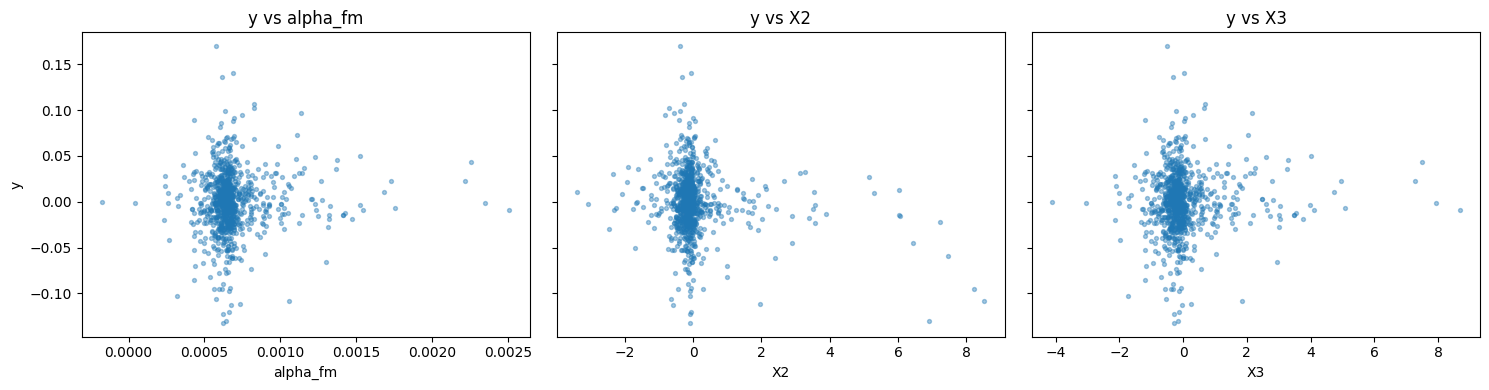

In [ ]:
#Observe the patterns vs y

df_day = (
    alpha_fm.loc[alpha_fm["date"] == best_date, ["X2", "alpha_fm", "X3","y"]]
    .dropna()
)


fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
cols = ["alpha_fm","X2","X3"]
for ax, col in zip(axes, cols):
    ax.scatter(df_day[col], df_day["y"], s=8, alpha=0.4)
    ax.set_title(f"y vs {col}")
    ax.set_xlabel(col)
axes[0].set_ylabel("y")
fig.tight_layout()

From our plots, we can see that all three plots show a tight clump around the origin with no obvious linear slope I can see by eye. This indicates that there is no strong monotonic cross-section, and any predictive power is small and possibly conditional.

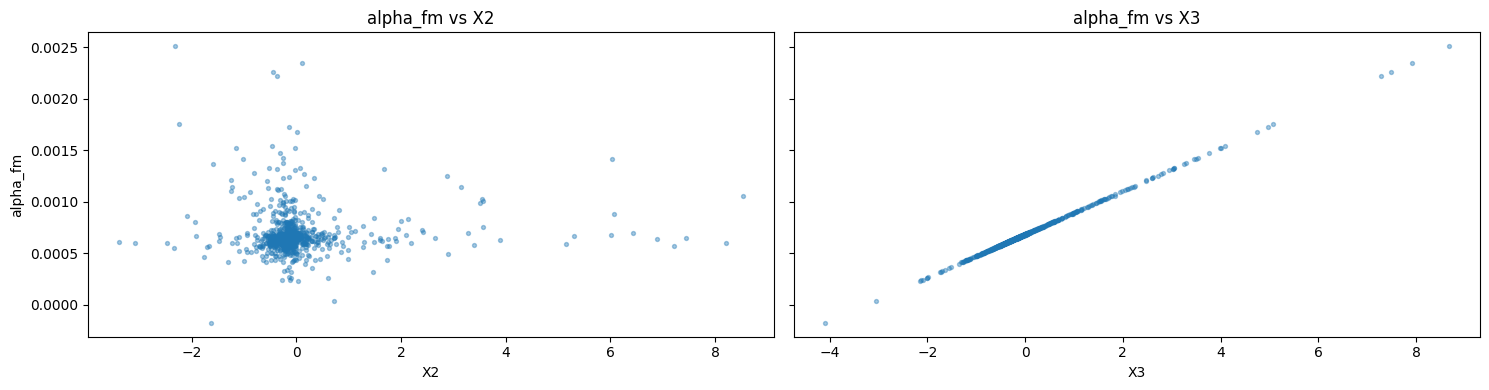

In [ ]:
#Observe the features vs alpha_fm

df_day = (
    alpha_fm.loc[alpha_fm["date"] == best_date, ["X2", "alpha_fm", "X3","y"]]
    .dropna()
)


fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
cols = ["X2","X3"]
for ax, col in zip(axes, cols):
    ax.scatter(df_day[col], df_day["alpha_fm"], s=8, alpha=0.4)
    ax.set_title(f"alpha_fm vs {col}")
    ax.set_xlabel(col)
axes[0].set_ylabel("alpha_fm")
fig.tight_layout()

This is very interesting. From the above graphs, we see the alpha_fm vs X2 plot is very cloudy around (0,0), indicating that X2 (gamma rolling sentiments times abnormal volume) doesn’t strongly dominate my alpha_fm construction. On the other hand, the alpha_fm vs X3 (theta rolling sentiments times abnormal volume) shows an almost perfect positive linear relation between alpha_fm and X3. This effectively means that my composite alpha is basically just a reweighted version of X3, meaning that because when I had earlier averaged betas across the training window, the regression likely found X3 consistently predictive, so X3 dominates. It explains why alpha_fm itself shows narrow dispersion: it’s inheriting X3’s distribution after shrinkage.

Moreover, earlier when we did the time series regression of y on both X2 and X3, it appears both factors were equally insignificant. This is likely due to the weak pooled fit reflects collinearity + noisy returns, making both X2 and X3 look insignificant, whereas in my rolling regression scheme, with shrinkage and averaging, ends up filtering out X2’s noise and letting X3’s more consistent relationship dominate.

## 3.2
Calculate the returns from your alpha factor in a reasonable and correct way. That is, the return someone trading on this alpha will (approximately) realize. As a hint, your answer should be a single timeseries.  

In [ ]:
backtest_df = alpha_fm[["date","tickerid","alpha_fm"]].merge(merged_df_cleaned[["tickerid", "date","averagedailytradingvolume", "d1"]], on=["tickerid", "date"], how="inner")


In [ ]:
#We rebalance the portfolio every 5 trading days, holding weights constant in between. This reduces turnover and trading costs while still capturing alpha signals, resulting in a more realistic and robust performance backtest.
# On each rebalance date, we select only the top 50% of stocks ranked by alpha scores, normalize their weights, and hold this basket for the next 5 days.
#We hope this represents a reasonable way to trade on the signal, as it reduces turnover and trading costs while concentrating exposure in the strongest signals.
def compute_alpha_timeseries_hold(
    df,
    stock_col="tickerid",
    date_col="date",
    alpha_col="alpha_fm",
    fwdret_col="d1",
    adv_col="averagedailytradingvolume",
    hold_days=5,
    top_frac=0.5
):
  df = df.copy()
  df = df.drop_duplicates(subset=[date_col, stock_col]).sort_values([date_col, stock_col])
  df = df.replace([np.inf, -np.inf], np.nan)
  # df = df.dropna(subset=[alpha_col, adv_col])

  # Ensure dates are sorted
  dates = pd.Index(pd.to_datetime(df[date_col].unique())).sort_values()

  # map each date -> its anchor date (the first date in its 5-day bucket)
  date_positions = pd.Series(np.arange(len(dates)), index=dates)
  anchor_idx = (date_positions // hold_days) * hold_days
  anchors = dates[anchor_idx.values]
  date_map = pd.DataFrame({date_col: dates, "anchor_date": anchors})

  # Attach the anchor_date map to the full panel
  df[date_col] = pd.to_datetime(df[date_col])
  df = df.merge(date_map, on=date_col, how="left")

  #Build weights ONLY on anchor dates, to prevent excessive rebalancing daily
  rebalance_panel = df[df[date_col] == df["anchor_date"]].copy()

  #Per-day z-score of alpha on anchor days
  g = rebalance_panel.groupby(date_col)
  mu = g[alpha_col].transform("mean")
  sd = g[alpha_col].transform("std").replace(0, np.nan)
  rebalance_panel["alpha_z"] = (rebalance_panel[alpha_col] - mu) / sd
  rebalance_panel = rebalance_panel.dropna(subset=["alpha_z"])

  # Long-only top fraction by alpha_z level on each anchor day
  pct = rebalance_panel.groupby(date_col)["alpha_z"].rank(pct=True, method="first")
  keep = pct >= (1.0 - top_frac)
  rebalance_panel["w_raw"] = np.where(keep, np.maximum(rebalance_panel["alpha_z"], 0.0), 0.0)
  #normalize
  pos_sum = rebalance_panel.groupby(date_col)["w_raw"].transform("sum")
  rebalance_panel["w"] = np.where(pos_sum > 0, rebalance_panel["w_raw"] / pos_sum, 0.0)
  weights = rebalance_panel[[date_col, "anchor_date", stock_col, "w"]].copy()

  #Apply weights across the 5-day holding window
  #For every (date, stock), attach the weight from its period's anchor_date
  #Names not in the anchor basket will have NaN weight -> treated as 0.
  ret_panel = df[[date_col, "anchor_date", stock_col, fwdret_col]].copy()
  ret_panel[fwdret_col] = ret_panel[fwdret_col].astype(float).fillna(0.0)
  ret_panel = ret_panel.merge(weights[[ "anchor_date", stock_col, "w"]], on=["anchor_date", stock_col], how="left")
  #Contribution = w(anchor_date, stock) * d1(date, stock)
  ret_panel["contrib"] = ret_panel["w"].fillna(0.0) * ret_panel[fwdret_col]

  daily_weights = ret_panel[[date_col, stock_col, "w"]].copy().rename(columns={"w": "weight"})
  daily_weights = daily_weights.sort_values([date_col, "weight"], ascending=[True, False]).reset_index(drop=True)

  # Sum across stocks per day
  daily_ret = ret_panel.groupby(date_col)["contrib"].sum().sort_index()
  daily_ret.name = "strategy_ret_gross"
  return daily_ret,daily_weights

In [ ]:
realized_ts, daily_weights = compute_alpha_timeseries_hold(backtest_df)
realized_ts

,strategy_ret_gross
date,
2015-01-08,0.004123
2015-01-09,0.004102
2015-01-12,-0.001990
2015-01-13,-0.003334
2015-01-14,-0.001324
...,...
2019-12-18,-0.003333
2019-12-19,-0.000397
2019-12-20,0.001346


In [ ]:
print(f"portfolio returns, pre fees: {100*((realized_ts+1).prod()-1):.2f}% over 5 years")
n_years = len(realized_ts) / 252
cagr = ( (realized_ts+1).prod() )**(1/n_years) - 1
print(f"Annualized return, pre fees: {cagr*100:.2f}%")

portfolio returns, pre fees: 17.06% over 5 years
Annualized return, pre fees: 3.30%


## 3.3
If you were a portfolio manager evaluating these signals, what metrics would you like to see? Calculate these metrics and discuss your findings. How do these compare with purely statistical metrics like t-stats? Which do you prefer?

As a PM, I would mostly care about whether a signal can make money in a portfolio, survive real-world dynamics, and scale, not necessarily if it is just statistically significant.

Thus, my metrics would be:
- sharpe ratio: captures return per unit of risk. This allows me to evaluate if the signal produces consistent, risk-adjusted excess returns, not just noisy profits.
- Turnover-adjusted Sharpe (after costs): captures results after considering trading frictions, such as slippage and commissions. Tests if it can survive real world dynamics.
- Lagged IC (information coefficient) curve: captures how quickly the signal decays. A signal that only works at t+1 but vanishes (or reverses) at t+5 may not be robust or scalable, so this allows me to investigate signal decay.

In [ ]:
def sharpe_ratio(daily_ret):
  daily_ret = pd.Series(daily_ret).dropna()
  mean_ret = daily_ret.mean()
  vol_ret  = daily_ret.std()
  sharpe = (mean_ret / vol_ret)*np.sqrt(252)
  return sharpe

sharpe = sharpe_ratio(realized_ts)
print("Sharpe Ratio:", sharpe)

Sharpe Ratio: 1.0460750709034663


This sharpe ratio seems promising, indicating that there exists moderate risk-adjusted returns. Given our longer holding period of 5 days, this indicates that the sharpe isn’t being "manufactured" by high-frequency trading noise. Thus, the alpha has some persistence, which is valuable. Further testing will be needed to see if it is profitable, as well as how it performs with 1 day or 3 day holdings.

In [ ]:
realized_ts1,daily_weights1 = compute_alpha_timeseries_hold(backtest_df, hold_days = 3)
print("Sharpe Ratio with three day holding horizon:", sharpe_ratio(realized_ts1))
realized_ts1,daily_weights1 = compute_alpha_timeseries_hold(backtest_df, hold_days = 1)
print("Sharpe Ratio with one day holding horizon:", sharpe_ratio(realized_ts1))

Sharpe Ratio with three day holding horizon: 0.9244998176761815
Sharpe Ratio with one day holding horizon: 2.020644643427401


This is very interesting. Our one day sharpe is very strong, and our 3 day is slightly worse. This indicates our alpha has some persistence, but much of the edge fades after day 1. This overall suggests our alpha has fast signal decay. A 1-day horizon looks fantastic in gross terms, but high turnover rates will eat away at profits, so net Sharpe after costs may fall sharply.

In [ ]:
# we estimate 10 bps per day as we assume 5 bps per side for liquid stocks, so 10 bps round trip of buy and sell.
def turnover_adjusted_sharpe_from_weights(daily_weights, daily_ret, date_col="date", stock_col="tickerid",
                        hold_days=5, cost_bps=10):

    daily_weights = daily_weights.copy()
    daily_weights[date_col] = pd.to_datetime(daily_weights[date_col])
    dates = pd.Index(sorted(daily_weights[date_col].unique()))
    pos = pd.Series(range(len(dates)), index=dates)
    anchors = dates[(pos // hold_days) * hold_days]
    date_map = pd.DataFrame({date_col: dates, "anchor_date": anchors})
    w = daily_weights.merge(date_map, on=date_col, how="left")

    # snapshot portfolio only on anchor days
    w_anchor = w[w[date_col] == w["anchor_date"]]
    pivot = w_anchor.pivot_table(index=stock_col, columns=date_col, values="weight", fill_value=0.0)
    cols = pivot.columns.sort_values()

    # compute turnover between consecutive anchor snapshots
    turnover_anchor = {}
    for i in range(1, len(cols)):
        t_prev, t_now = cols[i-1], cols[i]
        turnover_anchor[t_now] = (pivot[t_now] - pivot[t_prev]).abs().sum()

    turnover_anchor = pd.Series(turnover_anchor)

        # expand into daily series (spiky on rebalance days)
    daily_turnover = pd.Series(0.0, index=dates)
    daily_turnover.loc[turnover_anchor.index] = turnover_anchor

    # costs
    cost_perc = cost_bps / 1e4
    daily_cost = daily_turnover * cost_perc
    daily_ret_net = daily_ret - daily_cost

    # sharpe
    vol = daily_ret.std()
    sharpe_gross = daily_ret.mean() / vol * np.sqrt(252) if vol > 0 else np.nan
    sharpe_net   = daily_ret_net.mean() / vol * np.sqrt(252) if vol > 0 else np.nan

    return {
        "Gross Sharpe": sharpe_gross,
        "After-cost Sharpe": sharpe_net,
        "Mean daily turnover": daily_turnover.mean(),
        "Mean daily cost": daily_cost.mean()
    }

turnover_adjusted_sharpe_from_weights(daily_weights, realized_ts)

{'Gross Sharpe': np.float64(1.0460750709034663),
 'After-cost Sharpe': np.float64(-1.5689966431459668),
 'Mean daily turnover': np.float64(0.32667093932173913),
 'Mean daily cost': np.float64(0.00032667093932173914)}

Our after-cost sharpe is in the negatives, meaning that the strategy updates the book so much that costs dominate the edge. This is further emphasized by mean daily turnover of 32%. This means on average we're turning over 32% of the portfolio every single day due to a large chunk of the book flipping each rebalance, making it very hard to monetize in the real world. We saw such promising sharpe ratio because we were simply rebalancing our book too much every rebalance day to effectively reduce our risk.

In [ ]:
def lagged_ic_curve(
    df,
    alpha_col="alpha_fm",
    ret_col="d1",
    date_col="date",
    stock_col="tickerid",
    max_lag=10,
    method="spearman"
):


  d = df[[date_col, stock_col, alpha_col]].dropna(subset=[alpha_col]).copy()
  d = d.merge(Full_df[["tickerid","date","d1"]], on = ["tickerid","date"], how = "left")
  d = d.sort_values([stock_col, date_col])

  # Precompute forward k-day returns via per-ticker shift,
  rets_by_lag = {}
  for k in range(0, max_lag + 1):
    rets_by_lag[k] = d.groupby(stock_col, sort=False)[ret_col].shift(-k)

  ic_daily = {}
  for k in range(0, max_lag + 1):
    dk = d.copy()
    dk["fwd_ret_k"] = rets_by_lag[k]

    dk = dk.dropna(subset=[alpha_col, "fwd_ret_k"])

    # per-day cross-sectional correlation
    def _cs_corr(g):
      x = g[alpha_col].to_numpy()
      y = g["fwd_ret_k"].to_numpy()
      if len(x) < 5:
        return np.nan
      if method == "spearman":
        r, _ = spearmanr(x, y)
      else:
        r, _ = pearsonr(x, y)
      return r

    ic_by_day = dk.groupby(date_col, sort=False).apply(_cs_corr, include_groups=False).astype(float)
    ic_daily[k] = ic_by_day

  rows = []
  for k, ser in ic_daily.items():
    ser = ser.dropna()
    n = ser.size
    mu = ser.mean() if n else np.nan
    sd = ser.std(ddof=1) if n > 1 else np.nan
    tstat = mu / (sd / np.sqrt(n)) if (n > 1 and sd > 0) else np.nan
    rows.append({"lag": k, "mean_ic": mu, "tstat_ic": tstat, "n_days": n})
  ic_summary = pd.DataFrame(rows).set_index("lag")

  return ic_daily, ic_summary



      mean_ic  tstat_ic  n_days
lag                            
0    0.002431  2.056481    1224
1    0.002193  1.932478    1223
2    0.002293  2.011498    1222
3    0.000903  0.819760    1221
4    0.000635  0.565038    1220
5   -0.000356 -0.323577    1219
6    0.000874  0.799014    1218
7    0.000265  0.237471    1217
8   -0.000615 -0.539818    1216
9    0.001393  1.224509    1215
10  -0.000699 -0.607617    1214


<Axes: title={'center': 'Lagged IC Curve (Spearman)'}, xlabel='lag'>

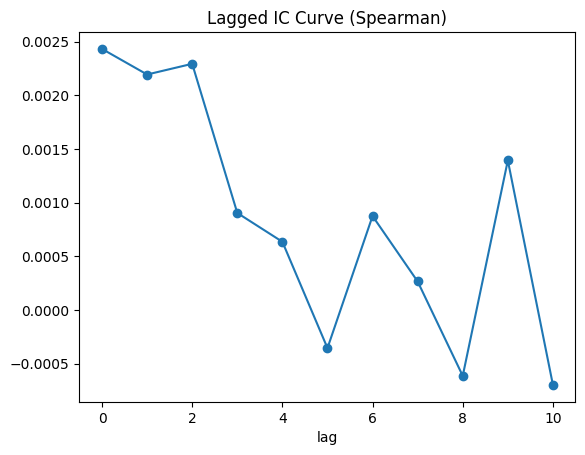

In [ ]:
ic_daily, ic_summary=lagged_ic_curve(alpha_fm)
print(ic_summary)
ic_summary["mean_ic"].plot(marker="o", title="Lagged IC Curve (Spearman)")

We can notice that our signal is strongest 1-2 days ahead, with t-values of around 2. This suggests that our alpha is able to genuinely anticipates returns 1–3 days ahead. However, in the medium horizon, our signal quickly decays, with IC scores of 0.000903  and 0.000635. Our t-stats fall below 1, meaning the effect is no longer statistically reliable. Past this, we see that our IC scores oscillate around 0, meaning no evidence of consistent predictive power. Thus, we can confirm our suspicions above: my signal is genuinely short-horizon, peaking at 1–2 days, gone by day 3–4, meaning we'd need daily to every-other-day rebalancing to harvest it, leading to the extreme trading costs we saw above.

As a PM, I would always prioritize on after-cost Sharpe, turnover, and decay curves metrics over pure t-stats. The conclusions we saw above confirm this, as even though we had high t-stats in lag 1 and lag 2, negative after-cost Sharpe reveals the edge is un-profitable without almost zero fees. Unlike pure statistical metrics such as T-stats that tell us "does something/pattern/trend exist there," and useful for diagnosing whether a signal is non-random, our metrics tell us "can I actually make money with this signal?" Since the ultimate test for us is if a signal is profitable, our PM metrics would be more informative overall.

# 4. Free Exploration and Discussion

## 4.1
Now that you understand the data and have the basics done, improve your alpha. Feel free to do anything you want here as long as it reasonably fits the goal of improving alpha. As a reminder, we will be reviewing this portion with a focus on creativity and research process.

The main concern I have with our alpha is that it decays too quickly, meaning we have rebalance frequently. To address this, we created a signal that captures when one group is reacting to news ahead of the other by measuring the disagreement between the Gamma and Theta networks. Intuitively, it’s like front-running the lagging network’s catch-up reaction. Our conviction in this signal comes from how retail chatter (high-frequency, emotional) vs. institutional discussion (slower, fundamentals-based) tend to resolve on different time scales. Normally sentiment signals decay quickly because everyone sees the same thing at the same time. But when gamma and theta disagree, it means not all investors are on the same page. That information gap creates a slower adjustment process, so the predictive power of the signal persists beyond just the next day. In practice, we see that disagreement-based signals often peak at day 2–3, extending horizon and reducing the turnover problem of short-lived alphas.

In [ ]:
def build_disagreement_signal(features, date_col = "date",
    stock_col = "tickerid",
    gamma_sent_col = "gamma_sentiment",
    theta_sent_col = "theta_sentiment",
    gamma_vol_col = "gamma_volume",
    theta_vol_col = "theta_volume",
    gamma_writers_col= "gamma_writers",
    theta_writers_col= "theta_writers",
    gic_col= "gic2",
    winsor= 0.01,
    # industry_neutral: bool = True,
    # return_components: bool = True
):
  f = features.copy()
  f["date"] = pd.to_datetime(f["date"])
  f = f.sort_values(["date", "tickerid"])

  def _winsor_per_day(df, col):
    g = df.groupby(date_col)[col]
    lo = g.transform(lambda s: s.quantile(winsor))
    hi = g.transform(lambda s: s.quantile(1-winsor))
    return df[col].clip(lo, hi)

  for c in [gamma_sent_col, theta_sent_col, gamma_vol_col, theta_vol_col, gamma_writers_col, theta_writers_col]:
    f[c] = _winsor_per_day(f, c)

  #Cross-sectional z-scores per day
  def _z_per_day(s):
    mu = s.groupby(f[date_col]).transform("mean")
    sd = s.groupby(f[date_col]).transform("std").replace(0, np.nan)
    return (s - mu) / sd

  f["z_gamma_sent"] = _z_per_day(f[gamma_sent_col])
  f["z_theta_sent"] = _z_per_day(f[theta_sent_col])

  f["disagree_base"] = f["z_gamma_sent"] - f["z_theta_sent"]   # positive => gamma >> theta

  #Breadth weighing - if many unique writers per message = broad participation (less echo-chamber)
  f["wpmsg_gamma"] = f[gamma_writers_col] / (1.0 + f[gamma_vol_col])
  f["wpmsg_theta"] = f[theta_writers_col] / (1.0 + f[theta_vol_col])

  #intensity - high combined message flow = stronger, more reliable divergence
  f["intensity_raw"] = (f[gamma_vol_col].fillna(0) + f[theta_vol_col].fillna(0))
  f["z_intensity"] = _z_per_day(f["intensity_raw"]).clip(lower=0)  # emphasize above-average attention

  #combine:
  f["breadth_raw"] = 0.5 * (f["wpmsg_gamma"].fillna(0) + f["wpmsg_theta"].fillna(0))
  f["z_breadth"] = _z_per_day(f["breadth_raw"]).clip(lower=0)

  boost = 1.0 + 0.5*f["z_intensity"] + 0.5*f["z_breadth"]
  f["alpha_disagree"] = f["disagree_base"] * boost

  cols = [date_col, stock_col, "alpha_disagree"]
  out = f[cols].sort_values([date_col, stock_col]).reset_index(drop=True)
  return out

In [ ]:
full_features_clean = features_clean_theta.merge(features_clean, on = ["tickerid","date"], how = "left")
disagreement_signal = build_disagreement_signal(full_features_clean)
disagreement_signal

,date,tickerid,alpha_disagree
0,2015-01-02,5,-2.070684
1,2015-01-02,6,0.258723
2,2015-01-02,10,0.266706
3,2015-01-02,30,0.458053
4,2015-01-02,57,0.026922
...,...,...,...
425222,2019-12-31,2474,-1.430180
425223,2019-12-31,2482,-1.858310
425224,2019-12-31,2488,2.637324
425225,2019-12-31,2492,-0.074616


Now that we have our disagreement, we construct the alpha signal. Similarly to before, we calculate by rolling cross-sectional Ridge regressions of future returns on features (X2, X3, disagreement signal), then averaging the regression coefficients with time decay + data quality weighting, and finally applying those coefficients to today’s feature values to produce alpha_fm_plus.

In [ ]:
def build_alpha_with_disagreement(
    Full_df: pd.DataFrame,
    disagreement_signal: pd.DataFrame,
    train_days: int = 63,
    min_n: int = 50,
    ridge_alpha: float = 1.0,
    winsor: tuple[float,float] = (0.01, 0.99),
    feat_cols_base = ("X2","X3"),
    disagree_col: str = "alpha_disagree",
    out_alpha_col: str = "alpha_fm_plus"
):

    # Assemble feature panel (left join; keep sparsity)
    F = Full_df[["date","tickerid"] + list(feat_cols_base)].copy()
    F = F.merge(disagreement_signal[["date","tickerid", disagree_col]],
                on=["date","tickerid"], how="left")
    all_feats = list(feat_cols_base) + [disagree_col]

    F["date"] = pd.to_datetime(F["date"])
    F = F.sort_values(["date","tickerid"])

    #Per-day winsorization then z-score (robust; keep NaNs)
    def _winsor_per_day(df, col):
        g = df.groupby("date")[col]
        lo = g.transform(lambda s: s.quantile(winsor[0]))
        hi = g.transform(lambda s: s.quantile(winsor[1]))
        return df[col].clip(lo, hi)

    for c in all_feats:
        F[c] = _winsor_per_day(F, c)

    for c in all_feats:
        mu = F.groupby("date")[c].transform("mean")
        sd = F.groupby("date")[c].transform("std").replace(0, np.nan)
        F[c] = (F[c] - mu) / sd

    #Target (5d forward)
    Y = Full_df[["date","tickerid","y"]].copy()
    Y["date"] = pd.to_datetime(Y["date"])
    Y = Y.dropna(subset=["y"])

    # Training rows need y and at least one feature present
    Ztrain = F.merge(Y, on=["date","tickerid"], how="inner")
    Ztrain = Ztrain.dropna(subset=["y"])
    Ztrain = Ztrain.dropna(subset=all_feats, how="all")
    apply_dates = np.array(sorted(F["date"].unique()))
    train_by_date = {d: g for d, g in Ztrain.groupby("date", sort=False)}

    # Rolling daily CS Ridge
    out = []
    for dt in tqdm(apply_dates):
        # strictly use training dates < dt
        hist = apply_dates[apply_dates < dt]
        if hist.size == 0:
            continue
        hist = hist[-train_days:]

        rows = []
        for dti in hist:
            gi = train_by_date.get(dti)
            if gi is None or len(gi) < min_n:
                continue
            gi = gi.dropna(subset=all_feats, how="all")
            if gi.empty:
                continue

            X = gi[all_feats].fillna(0.0).to_numpy(float)  # missing feature = neutral
            y = gi["y"].to_numpy(float)

            m = Ridge(alpha=ridge_alpha, fit_intercept=True)
            m.fit(X, y)

            rows.append(pd.Series(
                {"date": dti, "n": len(gi), "const": m.intercept_, **{f: coef for f, coef in zip(all_feats, m.coef_)}}
            ))

        if not rows:
            continue

        B = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)

        # Time-decay × quality weighting
        tw = np.arange(1, len(B)+1, dtype=float); tw /= tw.sum()
        qw = np.sqrt(B["n"].to_numpy(float))
        wts = tw * qw

        beta_cols = ["const"] + all_feats
        w_vec = (B[beta_cols].to_numpy(float) * wts[:, None]).sum(axis=0) / wts.sum()
        w = pd.Series(w_vec, index=beta_cols)

        # Apply to today's cross-section at dt
        g0 = F.loc[F["date"] == dt, ["date","tickerid"] + all_feats].copy()
        mask_valid = g0[all_feats].notna().any(axis=1)
        g0.loc[mask_valid, out_alpha_col] = (g0.loc[mask_valid, all_feats].fillna(0.0) @ w[all_feats].values) + w["const"]
        g0.loc[~mask_valid, out_alpha_col] = np.nan

        g0 = g0.merge(Y, on=["date","tickerid"], how="left")
        out.append(g0[["date","tickerid", out_alpha_col, "y"] + all_feats])

    alpha_plus = pd.concat(out, ignore_index=True).sort_values(["date","tickerid"])
    return alpha_plus


In [ ]:
alpha_plus = build_alpha_with_disagreement(Full_df, disagreement_signal,
                                           train_days=63, min_n=50, ridge_alpha=1.0)


100%|██████████| 1227/1227 [11:17<00:00,  1.81it/s]


In [ ]:
#Construct backtest database with new signal:
backtest_df_experiment = alpha_plus[["date","tickerid","alpha_fm_plus"]].merge(merged_df_cleaned[["tickerid", "date","averagedailytradingvolume", "d1"]], on=["tickerid", "date"], how="inner")


In [ ]:
#To deal with the issue of my book flipping too much every rebalance, we implement two fixes.
#First, we implement exponential moving weightted average on z-scored features so day-to-day noise doesn’t cause rank flips
# we then add Hysteresis bands so that once a stock is in the portfolio, we only drop it if it falls below top 45%.
def compute_alpha_timeseries_hold1(
    df,
    stock_col="tickerid",
    date_col="date",
    alpha_col="alpha_fm",
    fwdret_col="d1",
    adv_col="averagedailytradingvolume",
    hold_days=5,
    top_frac=0.50,           # enter if in top 50%
    hysteresis_band=0.05,    # only drop if it falls below top (50%-5%) = top 45%
    ewma_halflife=3          # EWMA smoothing across anchor snapshots
):
    df = df.copy()
    df = df.drop_duplicates(subset=[date_col, stock_col]).replace([np.inf, -np.inf], np.nan)
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([date_col, stock_col])

    dates = pd.Index(df[date_col].unique()).sort_values()
    pos = pd.Series(np.arange(len(dates)), index=dates)
    anchor_idx = (pos // hold_days) * hold_days
    anchors = dates[anchor_idx.values]
    date_map = pd.DataFrame({date_col: dates, "anchor_date": anchors})
    df = df.merge(date_map, on=date_col, how="left")

    # Build panel only on anchor days for signal/selection
    anchor_panel = df[df[date_col] == df["anchor_date"]].copy()

    # Cross-sectional z-score of alpha on each anchor date
    g = anchor_panel.groupby(date_col)
    mu = g[alpha_col].transform("mean")
    sd = g[alpha_col].transform("std").replace(0, np.nan)
    anchor_panel.loc[:, "alpha_z"] = (anchor_panel[alpha_col] - mu) / sd
    anchor_panel = anchor_panel.dropna(subset=["alpha_z"])

    # Sort by anchor date then stock; apply ewm to alpha_z within each stock
    anchor_panel = anchor_panel.sort_values([stock_col, date_col])
    anchor_panel.loc[:, "alpha_z_smooth"] = (
        anchor_panel.groupby(stock_col)["alpha_z"]
                    .transform(lambda s: s.ewm(halflife=ewma_halflife, adjust=False).mean())
    )

    # Hysteresis thresholds
    entry_pct = 1.0 - top_frac
    exit_pct  = 1.0 - (top_frac - hysteresis_band)

    # Percentile ranks per anchor day on smoothed alpha
    anchor_panel.loc[:, "rank_pct"] = anchor_panel.groupby(date_col)["alpha_z_smooth"]\
                                                  .rank(pct=True, method="first")

    # Iterate over anchors to apply hysteresis
    anchor_dates = pd.Index(anchor_panel[date_col].unique()).sort_values()
    in_prev = set()   # stocks held as of previous anchor
    rows = []

    for t in anchor_dates:
        block = anchor_panel[anchor_panel[date_col] == t]

        enter = set(block.loc[block["rank_pct"] >= entry_pct, stock_col])

        keep  = set(block.loc[block["rank_pct"] >= exit_pct, stock_col]) & in_prev
        in_now = keep | (enter - in_prev)  # union; new entrants + kept


        b = block[[date_col, stock_col, "alpha_z_smooth"]].copy()
        b.loc[:, "w_raw"] = np.where(
            b[stock_col].isin(in_now),
            np.maximum(b["alpha_z_smooth"], 0.0),
            0.0
        )
        s = b["w_raw"].sum()
        b.loc[:, "w"] = np.where(s > 0, b["w_raw"] / s, 0.0)

        rows.append(b[[date_col, stock_col, "w"]])
        in_prev = in_now

    if not rows:
        empty_ret = pd.Series(dtype=float, name="strategy_ret_gross")
        empty_wts = pd.DataFrame(columns=[date_col, stock_col, "weight"])
        return empty_ret, empty_wts

    # Concatenate anchor weights
    anchor_weights = pd.concat(rows, ignore_index=True)
    anchor_weights = anchor_weights.rename(columns={"w": "weight"})


    ret_panel = df[[date_col, "anchor_date", stock_col, fwdret_col]].copy()
    ret_panel[fwdret_col] = ret_panel[fwdret_col].astype(float).fillna(0.0)

    ret_panel = ret_panel.merge(
        anchor_weights.rename(columns={date_col: "anchor_date"}),
        on=["anchor_date", stock_col],
        how="left"
    )
    ret_panel["weight"] = ret_panel["weight"].fillna(0.0)

    # Daily contributions & returns
    ret_panel["contrib"] = ret_panel["weight"] * ret_panel[fwdret_col]
    daily_ret = ret_panel.groupby(date_col)["contrib"].sum().sort_index()
    daily_ret.name = "strategy_ret_gross"

    # Daily weights output (frozen within block)
    daily_weights = ret_panel[[date_col, stock_col, "weight"]].copy()
    daily_weights = daily_weights.sort_values([date_col, "weight"], ascending=[True, False]).reset_index(drop=True)

    return daily_ret, daily_weights
#
realized_ts_experiment,weights_experiment = compute_alpha_timeseries_hold1(backtest_df_experiment, alpha_col="alpha_fm_plus", hold_days= 5,top_frac = .5)

Testing this new alpha:

In [ ]:
print("Sharpe Ratio:",  sharpe_ratio(realized_ts_experiment))

Sharpe Ratio: 3.136392141390003


This is an almost unrealistic stellar sharpe ratio, so I will treat it with a big grain of salt. Likely something we only see in research (now) but will quickly disappear when tested.

To test it, we examine the post cost sharpe ratio:

In [ ]:
turnover_adjusted_sharpe_from_weights(weights_experiment, realized_ts_experiment)

{'Gross Sharpe': np.float64(3.136392141390003),
 'After-cost Sharpe': np.float64(1.206536609687359),
 'Mean daily turnover': np.float64(0.1703761086439244),
 'Mean daily cost': np.float64(0.00017037610864392437)}

This seems pretty promising! Our after-cost sharpe being 1.2 is still very strong, and our mean daily turnover of 17% is moderate and expected when we rebalance the books pretty drastically every rebalance period.

      mean_ic  tstat_ic  n_days
lag                            
0   -0.000739 -0.652682    1226
1    0.000064  0.061067    1225
2    0.001022  0.937391    1224
3    0.002737  2.571792    1223
4    0.001167  1.072672    1222
5   -0.000069 -0.063249    1221
6    0.000277  0.263990    1220
7    0.001386  1.313111    1219
8   -0.001015 -0.929795    1218
9    0.000187  0.179553    1217
10   0.000735  0.698184    1216


<Axes: title={'center': 'Lagged IC Curve (Spearman)'}, xlabel='lag'>

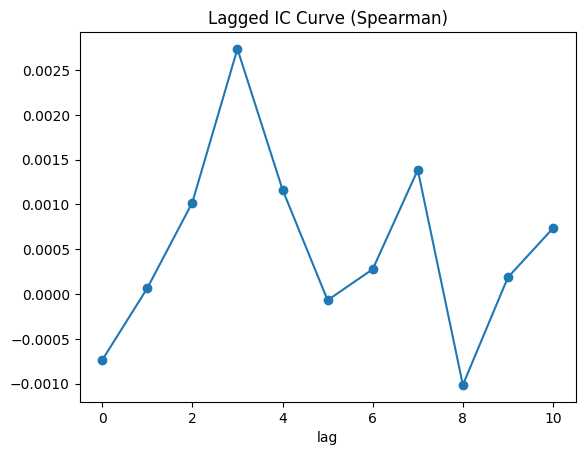

In [ ]:
ic_daily, ic_summary=lagged_ic_curve(alpha_plus, alpha_col = "alpha_fm_plus")
print(ic_summary)
ic_summary["mean_ic"].plot(marker="o", title="Lagged IC Curve (Spearman)")

From the above table and graph, this signal seems to capture slower-moving information that plays out over multiple days. It is best suited for holding horizons of 3–5 days rather than daily rebalancing. That's good, it partially explains why our signal does so well since we are using longer holding periods.

Overall, this new signal looks extremely promising. However, I am a little skeptical of the pre-cost sharpe ratio of 3. I tried everything I can think of in terms of spotting look-ahead bias, feature selection bias, and any other influences that could exaggerate the sharpe ratio, but couldn't find any. I don't have a lot of conviction that this signal truly has such stellar returns, so I am quite confident there is something I missed. I would love to have another pair of eyes on my work and receive feedback, so I can know how to improve in the future.

## 4.2
What are some limitations of this research? What would you do differently give more resources (time, compute, people), etc.?

If you have strong feelings about this test (good or bad), do share. If you don't think this test was a good demonstrations of your skills / capabilities, feel free to say so and why.

I think the main limitations from this research are the in two parts. For the part from my own modelling, I recognize potential weaknesses in cross-sectional density bias while determining alpha, sinc z-scoring per day implicitly assumes a “complete” cross-section. If many names are missing on a given day, then the scaling changes and can create misleading relative signals. Additionally, the missing vender gaps and lack of fully descriptive information limited exactly how I could work with the data. For example, we aren't told what gamma and theta represents in terms of platforms, whether one is more catered to retail vs institutional. As a result, it was harder to build an intuitive understanding of how sentiment may affect stock prices.

If I had more resources, I would like to examine how sentiment is collected more closely to see if we can get more reliable data. This would include using nlp analysis of analyst reports as well to balance out potentially retail chatter with institutional opinions, or delay each source by realistic ingest times (for example, Reddit right be not delayed at all, but analyst notes might be delayed a couple hours or days).